In [1]:
import xarray as xr
from os.path import join
import numpy as np
# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
exps=['default','2015co2']
# var='ssi'
result_dict1 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}
def change(data,yied,ssp):
    data = data[1:].rename({'year': 'time'})
    # if ssp == 'historical':
    data['time']=yied.time.values
    return data.where(np.isfinite(data))

for exp in exps:
    for ssp in ssps:
        if exp =='2015co2' and ssp=='historical':
            continue
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    ssi_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    spei_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    spei_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median_{exp}.nc'))[f'yield-wwh-noirr'][-len(ssi_data_wwh):-1]
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median_{exp}.nc'))[f'yield-swh-noirr'][-len(ssi_data_wwh):-1]
                    ssi_data_wwh=change(ssi_data_wwh,yied_wwh,ssp)
                    ssi_data_swh=change(ssi_data_swh,yied_wwh,ssp)
                    spei_data_swh=change(spei_data_swh,yied_wwh,ssp)
                    spei_data_wwh=change(spei_data_wwh,yied_wwh,ssp)
                    
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    ssi=ssi_data_wwh.where(area_wwh>0).fillna(0)+ssi_data_swh.where(area_swh>0).fillna(0)
                    spei=spei_data_wwh.where(area_wwh>0).fillna(0)+spei_data_swh.where(area_swh>0).fillna(0)
                    result_dict1[exp][ssp][crop]['yield'] =yied.where(yied!=0)
                    result_dict1[exp][ssp][crop]['spei'] = spei.where(spei!=0)
                    result_dict1[exp][ssp][crop]['ssi'] = ssi.where(ssi!=0)
                except FileNotFoundError:
                    print(f"Warning: 缺少小麦数据文件 for {var}-{ssp}")
                    continue
            else:
                # try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    spei_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_{exp}.nc'))[f'yield-{crop}-noirr'][-len(ssi_data):-1]
                    ssi_data=change(ssi_data,yied,ssp)
                    spei_data=change(spei_data,yied,ssp)
                    result_dict1[exp][ssp][crop]['yield'] =yied.where(area>0)
                    result_dict1[exp][ssp][crop]['spei'] = spei_data.where(area>0)
                    result_dict1[exp][ssp][crop]['ssi'] = ssi_data.where(area>0)


In [2]:
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict2 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}
exps=['default','2015co2']
for exp in exps:
    for ssp in ssps:
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
                yied= xr.open_dataset(join(fp, f'expected_yield_wwh_{ssp}_{exp}_v2.nc'))[f'expected_yield'].fillna(0)+\
                 xr.open_dataset(join(fp, f'expected_yield_swh_{ssp}_{exp}_v2.nc'))[f'expected_yield'].fillna(0)
                p_value= xr.open_dataset(join(fp, f'expected_yield_swh_{ssp}_{exp}_v2.nc'))[f'p_value']+\
                xr.open_dataset(join(fp, f'expected_yield_wwh_{ssp}_{exp}_v2.nc'))[f'p_value']
                
                result_dict2[exp][ssp][crop]['expect_yield'] =yied.where(yied!=0)
                result_dict2[exp][ssp][crop]['p_value'] = p_value.where(p_value!=0)
    
            else:
                fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
                yied= xr.open_dataset(join(fp, f'expected_yield_{crop}_{ssp}_{exp}_v2.nc'))[f'expected_yield']
                p_value= xr.open_dataset(join(fp, f'expected_yield_{crop}_{ssp}_{exp}_v2.nc'))[f'p_value']
                result_dict2[exp][ssp][crop]['expect_yield'] =yied
                result_dict2[exp][ssp][crop]['p_value'] = p_value

In [4]:
def classify_drought_flood_impact(yield_ds, ssi_ds, ssi_threshold_drought=-0.3, ssi_threshold_flood=0.3):
    # 保证 SSI 和产量沿 time 维度对齐
    ssi_ds, yield_ds = xr.align(ssi_ds, yield_ds, join='inner')
    
    # 构造与时间坐标一致的掩码
    drought_mask = ssi_ds < ssi_threshold_drought
    flood_mask = ssi_ds > ssi_threshold_flood
    normal_mask = ~(drought_mask | flood_mask)

    # 分别筛选三类年份的产量
    yield_drought = yield_ds.where(drought_mask)
    yield_flood = yield_ds.where(flood_mask)
    yield_normal = yield_ds.where(normal_mask)

    # 对时间求平均（忽略 NaN）
    mean_drought = yield_drought.mean(dim="time", skipna=True)
    mean_flood = yield_flood.mean(dim="time", skipna=True)
    mean_normal = yield_normal.mean(dim="time", skipna=True)

    # 与正常年相比的减产量（负值代表减产）
    drought_loss = mean_drought - mean_normal
    flood_loss = mean_flood - mean_normal

    # 初始化分类图（0=无显著影响，1=干旱主导，2=洪涝主导，3=共同主导）
    classification = xr.full_like(mean_drought, 0, dtype=int)

    both_dominated = (drought_loss < -0) & (flood_loss < -0)
    drought_dominated = (drought_loss < -0) & (flood_loss >= -0)
    flood_dominated = (flood_loss < -0) & (drought_loss >= -0)

    classification = classification.where(~both_dominated, 3)
    classification = classification.where(~drought_dominated, 1)
    classification = classification.where(~flood_dominated, 2)

    return classification


In [30]:
def classify_drought_flood_impact(yield_ds, ssi_ds, ssi_threshold_drought=ssi_10pct, ssi_threshold_flood=-ssi_10pct):
    # 保证 SSI 和产量沿 time 维度对齐
    ssi_ds, yield_ds = xr.align(ssi_ds, yield_ds, join='inner')
    
    # 构造与时间坐标一致的掩码
    drought_mask = (ssi_ds < ssi_threshold_drought)
    flood_mask = (ssi_ds > ssi_threshold_flood)
    normal_mask = ~(drought_mask | flood_mask)

    # 分别筛选三类年份的产量
    yield_drought = yield_ds.where(drought_mask)
    yield_flood = yield_ds.where(flood_mask)
    yield_normal = yield_ds.where(normal_mask)

    # 对时间求平均（忽略 NaN）
    mean_drought = yield_drought.mean(dim="time", skipna=True)
    mean_flood = yield_flood.mean(dim="time", skipna=True)
    mean_normal = yield_normal.mean(dim="time", skipna=True)

    # 与正常年相比的减产量（负值代表减产）
    drought_loss = (yield_drought <0).sum(dim='time')/yield_drought.count(dim='time')
    flood_loss = (yield_flood <0).sum(dim='time')/yield_drought.count(dim='time') 

    # 初始化分类图（0=无显著影响，1=干旱主导，2=洪涝主导，3=共同主导）
    classification = xr.full_like(mean_drought, 0, dtype=int)

    both_dominated = (drought_loss < -0) & (flood_loss < -0)
    drought_dominated = (drought_loss < -0) & (flood_loss >= -0)
    flood_dominated = (flood_loss < -0) & (drought_loss >= -0)

    classification = classification.where(~both_dominated, 3)
    classification = classification.where(~drought_dominated, 1)
    classification = classification.where(~flood_dominated, 2)

    # return drought_loss,flood_loss
    return mean_drought,mean_flood
    # return classification


ssp = 'historical'
crop = 'mai'
area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
yield_ds = result_dict1[ssp][crop]['yield']-result_dict2[ssp][crop]['expect_yield']
ssi_ds = result_dict1[ssp][crop]['ssi']
drought_loss,flood_loss= classify_drought_flood_impact(yield_ds[-30:], ssi_ds[-30:])
drought_loss,flood_loss= classify_drought_flood_impact(yield_ds[-30:], ssi_ds[-30:])
# impact_classification = classify_drought_flood_impact(yield_ds[-30:], ssi_ds[-30:])
# impact_classification.name = "impact_type"
# impact_classification.attrs['description'] = "1=干旱主导，2=洪涝主导，3=共同主导，0=无主导"
# impact_classification=impact_classification.where(area>0)
# impact_classification.plot( figsize=(10, 6))



# print(f'干旱：{((impact_classification==1).sum()/impact_classification.count()*100).values}')
# print(f'洪涝：{((impact_classification==2).sum()/impact_classification.count()*100).values}')
# print(f'共同：{((impact_classification==3).sum()/impact_classification.count()*100).values}')
# print(f'sss：{((impact_classification==0).sum()/impact_classification.count()*100).values}')

In [9]:
def ana(data):
    return data-data.mean()

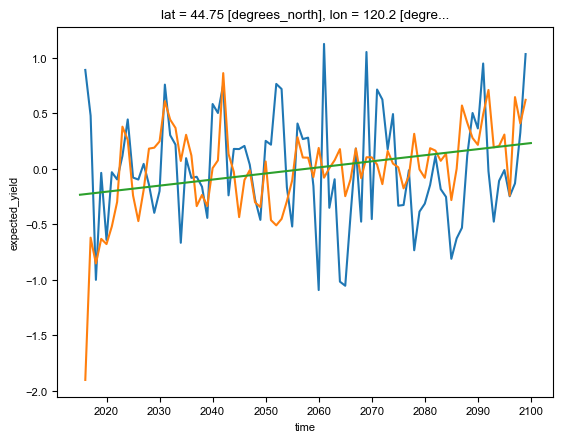

In [10]:
ana(result_dict1[ssp][crop]['yield'][:,90,600]-result_dict2[ssp][crop]['expect_yield'][:,90,600]).plot()
ana(result_dict1[ssp][crop]['ssi'][:,90,600]).plot()
ana(result_dict2[ssp][crop]['expect_yield'][:,90,600]).plot()

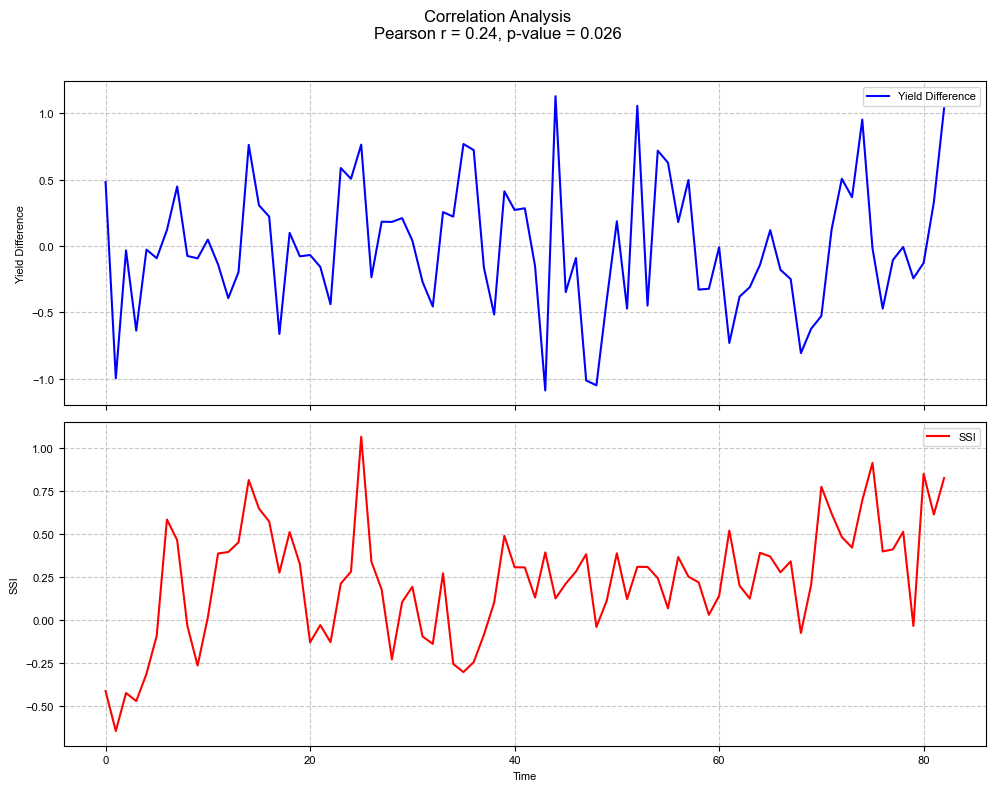

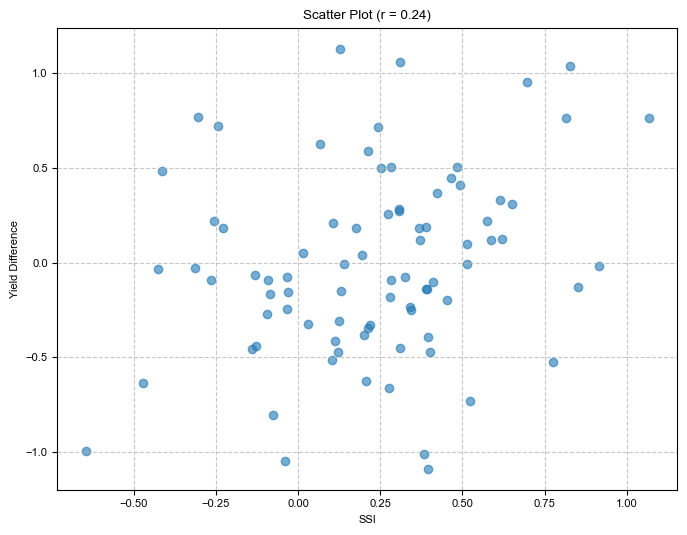

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# 提取数据
yield_diff = result_dict1[ssp][crop]['yield'][1:,90,600] - result_dict2[ssp][crop]['expect_yield'][:,90,600]
ssi_data = result_dict1[ssp][crop]['ssi'][1:,90,600]

# 计算相关性
corr_coef, p_value = stats.pearsonr(yield_diff, ssi_data)

# 创建图形
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 绘制第一个序列
ax1.plot(yield_diff, color='blue', label='Yield Difference')
ax1.set_ylabel('Yield Difference')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# 绘制第二个序列
ax2.plot(ssi_data, color='red', label='SSI')
ax2.set_xlabel('Time')
ax2.set_ylabel('SSI')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# 添加相关性信息
plt.suptitle(f'Correlation Analysis\nPearson r = {corr_coef:.2f}, p-value = {p_value:.3f}', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为suptitle留出空间

# 可选：添加散点图查看相关性分布
fig, ax3 = plt.subplots(figsize=(8, 6))
ax3.scatter(ssi_data, yield_diff, alpha=0.6)
ax3.set_xlabel('SSI')
ax3.set_ylabel('Yield Difference')
ax3.set_title(f'Scatter Plot (r = {corr_coef:.2f})')
ax3.grid(True, linestyle='--', alpha=0.7)
plt.show()

Spearman 相关系数: 0.621, p值: 3.767e-13
线性回归斜率: 0.2967, 截距: -0.0123, R²: 0.451, p值: 7.540e-16


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\IPython\co

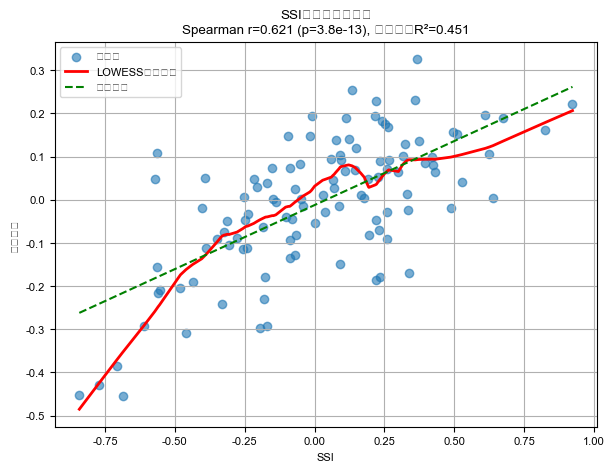

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, linregress
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
ssp='historical'
yield_diff = result_dict1[ssp][crop]['yield'][1:,82,426] - result_dict2[ssp][crop]['expect_yield'][:,82,426]
ssi_data = result_dict1[ssp][crop]['ssi'][1:,82,426]
# 准备数据，去除nan
x = np.asarray(ssi_data).ravel()
y = np.asarray(yield_diff).ravel()
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

if len(x) == 0:
    raise ValueError("无有效数据点")

# 计算Spearman相关
rho, p_spearman = spearmanr(x, y)
print(f"Spearman 相关系数: {rho:.3f}, p值: {p_spearman:.3e}")

# 简单线性回归
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f"线性回归斜率: {slope:.4f}, 截距: {intercept:.4f}, R²: {r_value**2:.3f}, p值: {p_value:.3e}")

# 绘图
plt.figure(figsize=(7,5))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体，Windows常用“SimHei”或“Microsoft YaHei”
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
plt.scatter(x, y, alpha=0.6, label='数据点')

# LOWESS平滑
lowess_frac = 0.2
smoothed = lowess(y, x, frac=lowess_frac, return_sorted=True)
plt.plot(smoothed[:,0], smoothed[:,1], color='red', linewidth=2, label='LOWESS平滑曲线')

# 线性回归直线
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = intercept + slope * x_line
plt.plot(x_line, y_line, color='green', linestyle='--', label='线性回归')

plt.xlabel('SSI')
plt.ylabel('产量损失')
plt.title(f'SSI与产量损失关系\nSpearman r={rho:.3f} (p={p_spearman:.1e}), 线性回归R²={r_value**2:.3f}')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# 计算每个网格点的10%分位值
ssi_10pct = ssi_ds.quantile(0.1, dim='time', skipna=True)

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


干旱：34.10881339241753
洪涝：5.108321024126046
共同：4.991383554899064
sss：55.79148202855736


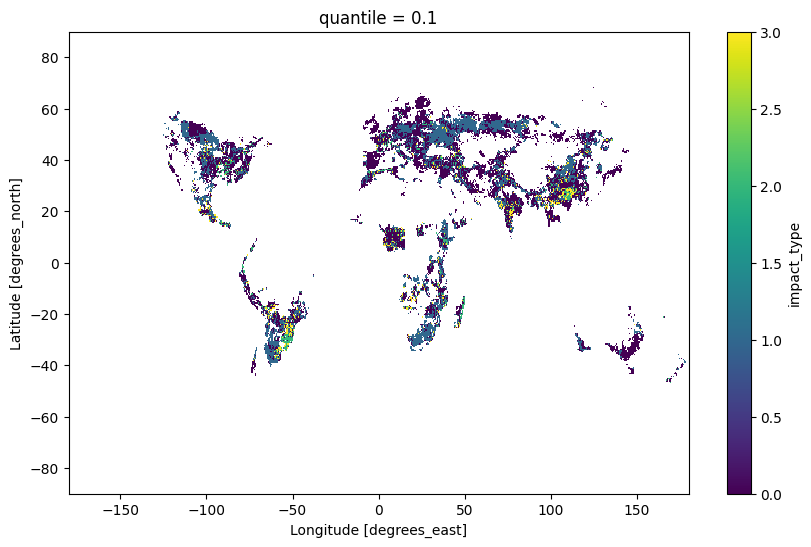

In [42]:
def classify_drought_flood_impact(yield_ds, ssi_ds, ssi_threshold_drought=ssi_10pct, ssi_threshold_flood=-ssi_10pct):
    # 保证 SSI 和产量沿 time 维度对齐
    ssi_ds, yield_ds = xr.align(ssi_ds, yield_ds, join='inner')
    
    # 构造与时间坐标一致的掩码
    drought_mask = (ssi_ds < ssi_threshold_drought)
    flood_mask = (ssi_ds > ssi_threshold_flood)
    normal_mask = ~(drought_mask | flood_mask)

    # 分别筛选三类年份的产量
    yield_drought = yield_ds.where(drought_mask)
    yield_flood = yield_ds.where(flood_mask)
    yield_normal = yield_ds.where(normal_mask)

    # 对时间求平均（忽略 NaN）
    mean_drought = yield_drought.mean(dim="time", skipna=True)
    mean_flood = yield_flood.mean(dim="time", skipna=True)
    mean_normal = yield_normal.mean(dim="time", skipna=True)

    # 与正常年相比的减产量（负值代表减产）
    drought_loss = mean_drought 
    flood_loss = mean_flood 

    # 初始化分类图（0=无显著影响，1=干旱主导，2=洪涝主导，3=共同主导）
    classification = xr.full_like(mean_drought, 0, dtype=int)

    both_dominated = (drought_loss < 0) & (flood_loss < 0)
    drought_dominated = (drought_loss < 0) & (flood_loss > 0)
    flood_dominated = (flood_loss < -0) & (drought_loss > 0)

    classification = classification.where(~both_dominated, 3)
    classification = classification.where(~drought_dominated, 1)
    classification = classification.where(~flood_dominated, 2)

    return classification
ssp = 'historical'
crop = 'whe'
area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
yield_ds = result_dict1[ssp][crop]['yield']-result_dict2[ssp][crop]['expect_yield']
ssi_ds = result_dict1[ssp][crop]['ssi']

impact_classification = classify_drought_flood_impact(yield_ds[-30:], ssi_ds[-30:])
impact_classification.name = "impact_type"
impact_classification.attrs['description'] = "1=干旱主导，2=洪涝主导，3=共同主导，0=无主导"
impact_classification=impact_classification.where(area>0)
impact_classification.plot( figsize=(10, 6))



print(f'干旱：{((impact_classification==1).sum()/impact_classification.count()*100).values}')
print(f'洪涝：{((impact_classification==2).sum()/impact_classification.count()*100).values}')
print(f'共同：{((impact_classification==3).sum()/impact_classification.count()*100).values}')
print(f'sss：{((impact_classification==0).sum()/impact_classification.count()*100).values}')

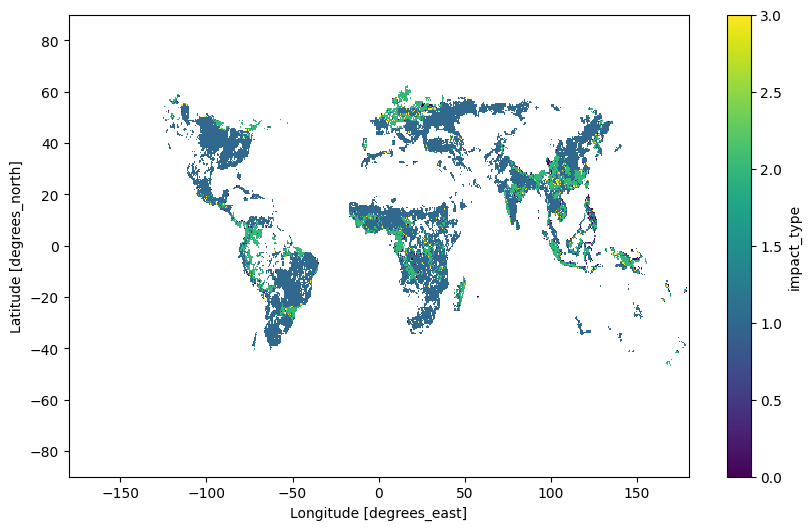

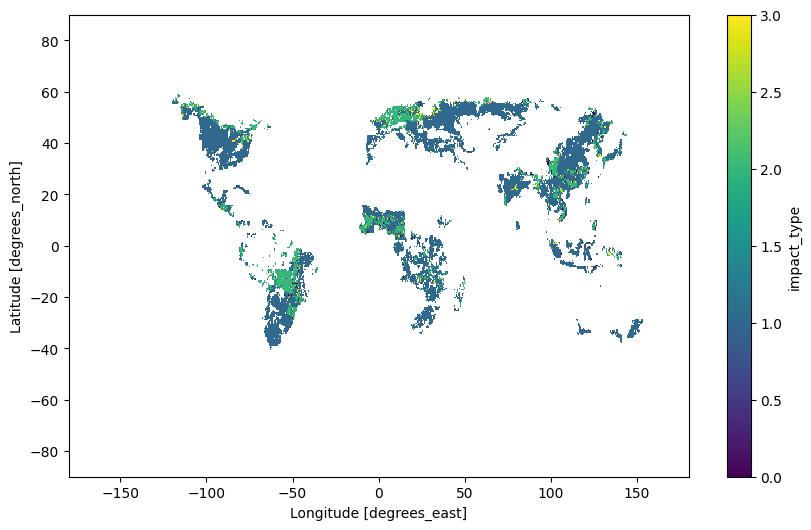

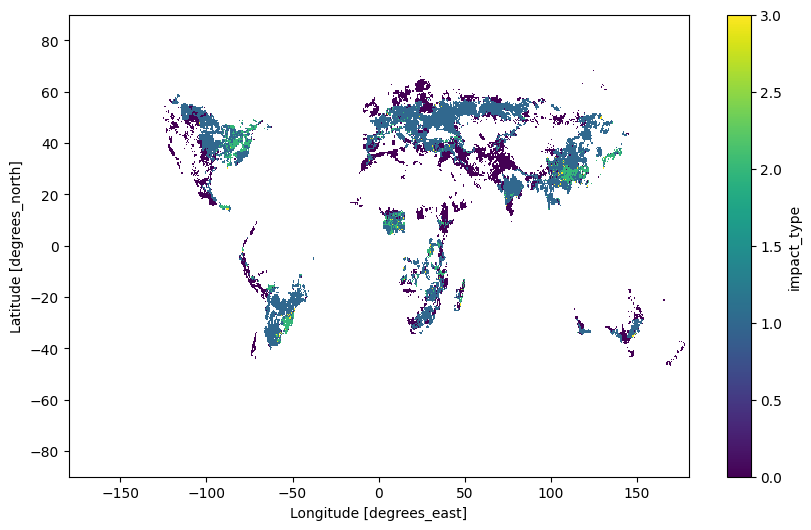

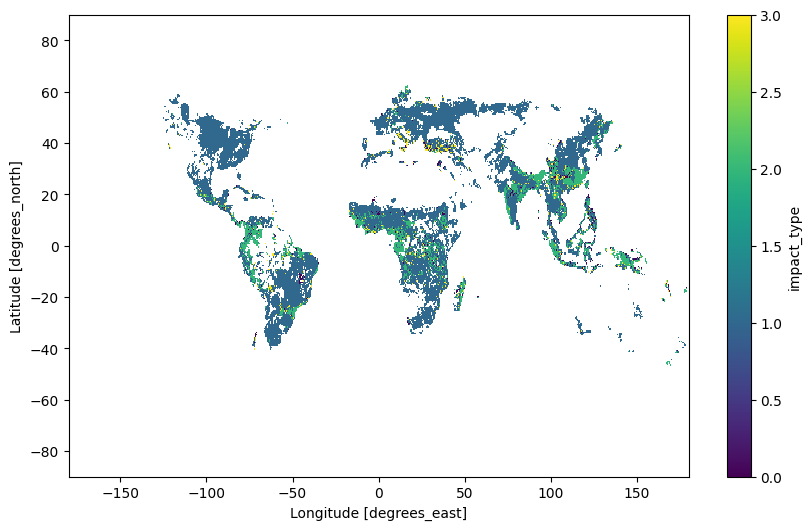

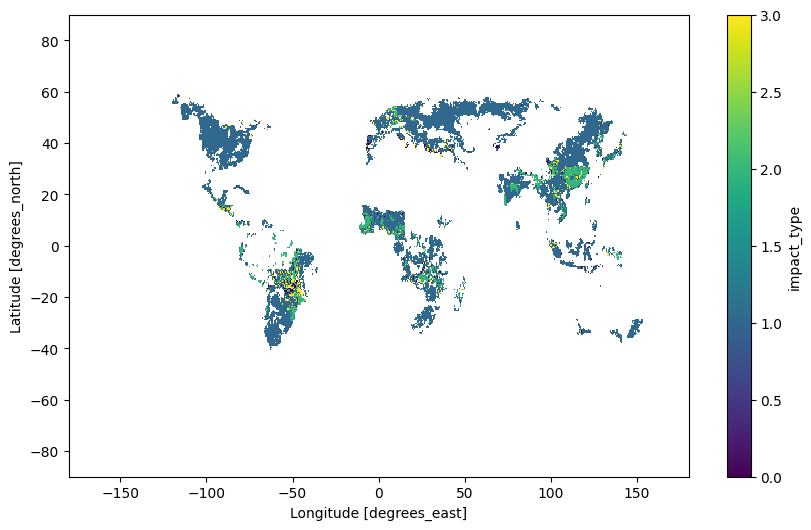

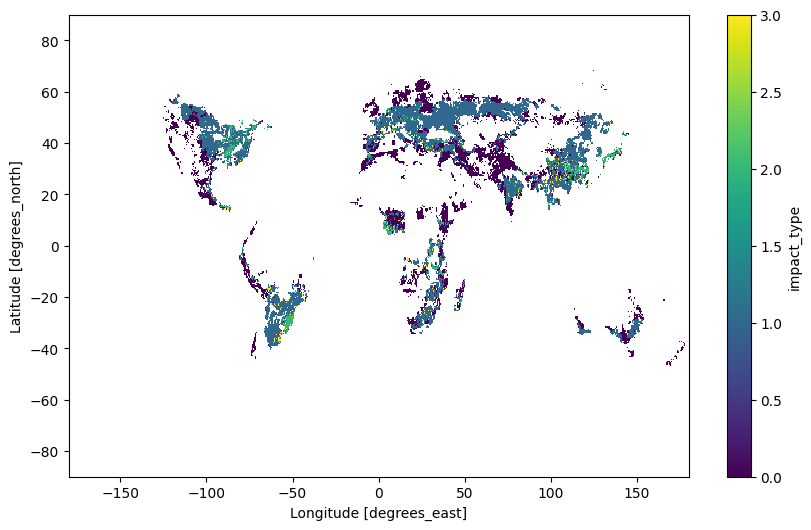

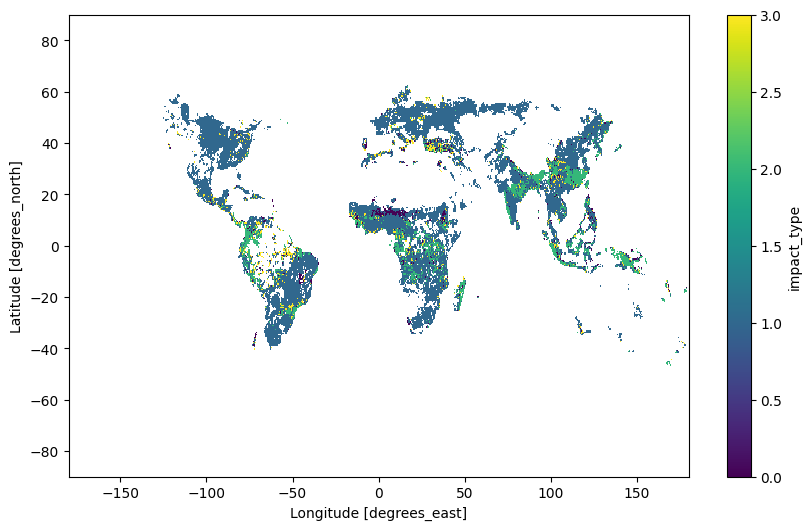

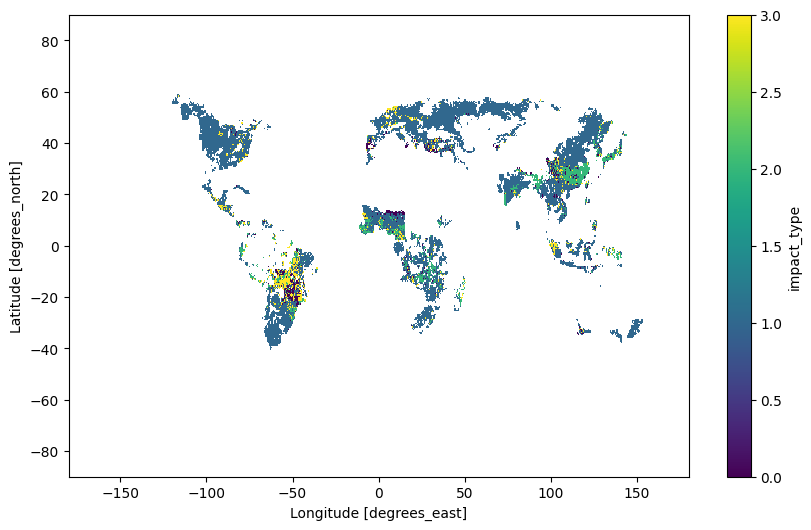

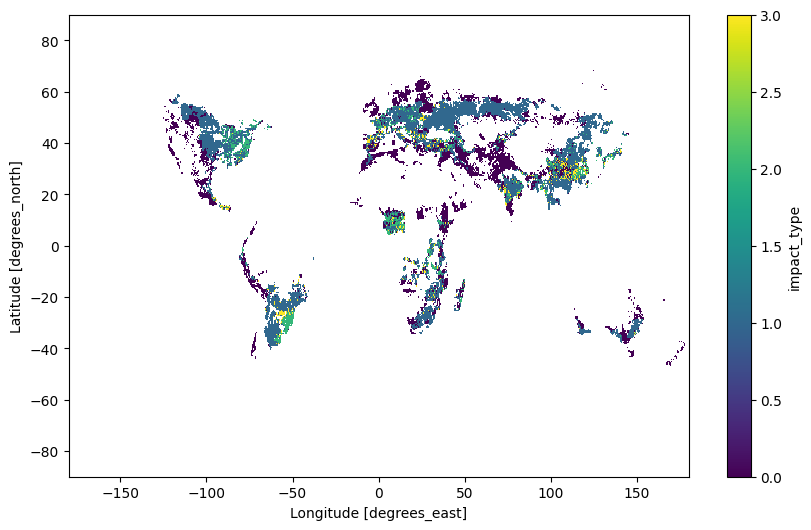

In [100]:
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
for ssp in ssps:
    for crop in crops:
        
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        # yield_ds = result_dict1[ssp][crop]['yield']
        # expect_yield = result_dict2[ssp][crop]['expect_yield']
        yield_ds=result_dict1[ssp][crop]['yield']-result_dict2[ssp][crop]['expect_yield']
        ssi_ds = result_dict1[ssp][crop]['ssi']
        ssi_ds['time']=yield_ds.time.values
        impact_classification = classify_drought_flood_impact(yield_ds, ssi_ds)
        impact_classification.name = "impact_type"
        impact_classification.attrs['description'] = "1=干旱主导，2=洪涝主导，3=共同主导，0=无主导"
        impact_classification=impact_classification.where(area>1000)
        # 保存结果
        impact_classification.to_netcdf(f"D:/AAUDE/paper/paper8/data/copula/impact_type_{crop}_{ssp}.nc")
        
        # 绘图（可选）
        impact_classification.plot( figsize=(10, 6))


In [4]:
import numpy as np
import xarray as xr
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from joblib import Parallel, delayed
def pcmcc(crop,ssp):
    max_lag = 0
    
    yield_da = result_dict1[ssp][crop]['yield']-result_dict2[ssp][crop]['expect_yield']
    ssi_da = result_dict1[ssp][crop]['ssi']
    spei_da = result_dict1[ssp][crop]['spei']
    
    lat = yield_da.lat.values
    lon = yield_da.lon.values
    
    def run_pcmci_for_pixel(yield_ts, ssi_ts, spei_ts, max_lag=0):
        if np.isnan(yield_ts).any() or np.isnan(ssi_ts).any() or np.isnan(spei_ts).any():
            return np.nan, np.nan, np.nan, np.nan
        try:
            data = np.array([yield_ts, ssi_ts, spei_ts]).T
            dataframe = pp.DataFrame(data, var_names=['yield', 'ssi', 'spei'])
            parcorr = ParCorr(significance='analytic')
            pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr)
            results = pcmci.run_pcmci(
                tau_max=0,
                pc_alpha=0.05,          # 让 PCMCI 选择父集（会把另一个指数纳入条件集中）
                fdr_method='fdr_bh'     # 多重检验校正（可选）
            )
    
            val_ssi = results['val_matrix'][1, 0, 0]
            pval_ssi = results['p_matrix'][1, 0, 0]
            val_spei = results['val_matrix'][2, 0, 0]
            pval_spei = results['p_matrix'][2, 0, 0]
    
            return val_ssi, pval_ssi, val_spei, pval_spei
        except:
            return np.nan, np.nan, np.nan, np.nan
    
    
    def process_pixel(i, j):
        # 注意你数据维度顺序，确保是时间在最后一维
        yield_ts = yield_da.isel(lat=i, lon=j).values
        ssi_ts = ssi_da.isel(lat=i, lon=j).values
        spei_ts = spei_da.isel(lat=i, lon=j).values
        return run_pcmci_for_pixel(yield_ts, ssi_ts, spei_ts, max_lag=max_lag)
    
    n_lat = len(lat)
    n_lon = len(lon)
    
    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(process_pixel)(i, j) for i in range(n_lat) for j in range(n_lon)
    )
    
    # 结果整理
    val_ssi_map = np.full((n_lat, n_lon), np.nan)
    pval_ssi_map = np.full((n_lat, n_lon), np.nan)
    val_spei_map = np.full((n_lat, n_lon), np.nan)
    pval_spei_map = np.full((n_lat, n_lon), np.nan)
    
    k = 0
    for i in range(n_lat):
        for j in range(n_lon):
            val_ssi_map[i, j], pval_ssi_map[i, j], val_spei_map[i, j], pval_spei_map[i, j] = results[k]
            k += 1
    
    output_ds = xr.Dataset(
        {
            'ssi_to_yield_strength': (['lat', 'lon'], val_ssi_map),
            'ssi_to_yield_pval': (['lat', 'lon'], pval_ssi_map),
            'spei_to_yield_strength': (['lat', 'lon'], val_spei_map),
            'spei_to_yield_pval': (['lat', 'lon'], pval_spei_map),
        },
        coords={'lat': lat, 'lon': lon}
    )
    
    output_ds.to_netcdf(rf"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_{crop}_{ssp}_default.nc")
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
for ssp in ssps:
        for crop in crops:
            pcmcc(crop,ssp)

ERROR! Session/line number was not unique in database. History logging moved to new session 1003


In [2]:
import xarray as xr
from os.path import join
import numpy as np
# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
exps=['default','2015co2']
# var='ssi'
result_dict1 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}
def change(data,yied,ssp):
    data = data[1:].rename({'year': 'time'})
    # if ssp == 'historical':
    data['time']=yied.time.values
    return data.where(np.isfinite(data))

for exp in exps:
    for ssp in ssps:
        if exp =='2015co2' and ssp=='historical':
            continue
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    ssi_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    spei_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    spei_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median_{exp}.nc'))[f'yield-wwh-noirr'][-len(ssi_data_wwh):-1]
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median_{exp}.nc'))[f'yield-swh-noirr'][-len(ssi_data_wwh):-1]
                    ssi_data_wwh=change(ssi_data_wwh,yied_wwh,ssp)
                    ssi_data_swh=change(ssi_data_swh,yied_wwh,ssp)
                    spei_data_swh=change(spei_data_swh,yied_wwh,ssp)
                    spei_data_wwh=change(spei_data_wwh,yied_wwh,ssp)
                    # swd=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_wwh_{ssp}_{exp}.nc')['swd'].where(area_wwh>0).fillna(0)+\
                    # xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_swh_{ssp}_{exp}.nc')['swd'].where(area_swh>0).fillna(0)
                    swd=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_wwh_{ssp}_median_{exp}.nc')['__xarray_dataarray_variable__'].where(area_wwh>0).fillna(0)+\
                    xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_swh_{ssp}_median_{exp}.nc')['__xarray_dataarray_variable__'].where(area_swh>0).fillna(0)
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    ssi=ssi_data_wwh.where(area_wwh>0).fillna(0)+ssi_data_swh.where(area_swh>0).fillna(0)
                    spei=spei_data_wwh.where(area_wwh>0).fillna(0)+spei_data_swh.where(area_swh>0).fillna(0)
                    result_dict1[exp][ssp][crop]['yield'] =yied.where(yied!=0)
                    result_dict1[exp][ssp][crop]['spei'] = spei.where(spei!=0)
                    result_dict1[exp][ssp][crop]['ssi'] = ssi.where(ssi!=0)
                    result_dict1[exp][ssp][crop]['swd'] = swd[:-1].where(swd[:-1]!=0)
                except FileNotFoundError:
                    print(f"Warning: 缺少小麦数据文件 for {var}-{ssp}")
                    continue
            else:
                # try:
                fp = r'D:\AAUDE\paper\paper8\data\result2'
                area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                ssi_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                spei_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_{exp}.nc'))[f'yield-{crop}-noirr'][-len(ssi_data):-1]
                # swd=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_{crop}_{ssp}_{exp}.nc')['swd'].where(area>0)
                swd=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_{crop}_{ssp}_median_{exp}.nc')['__xarray_dataarray_variable__'].where(area>0)
                ssi_data=change(ssi_data,yied,ssp)
                spei_data=change(spei_data,yied,ssp)
                result_dict1[exp][ssp][crop]['yield'] =yied.where(area>0)
                result_dict1[exp][ssp][crop]['spei'] = spei_data.where(area>0)
                result_dict1[exp][ssp][crop]['ssi'] = ssi_data.where(area>0)
                result_dict1[exp][ssp][crop]['swd'] = swd[:-1].where(swd[:-1]!=0)

In [5]:
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
# var='ssi'
result_dict2 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}
exps=['default','2015co2']
for exp in exps:
    for ssp in ssps:
        if exp == '2015co2' and ssp == 'historical':
            continue
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
                yied= xr.open_dataset(join(fp, f'exptct_yield_wwh_{ssp}_{exp}_smooth22.nc'))[f'yield-wwh-noirr'].fillna(0)+\
                 xr.open_dataset(join(fp, f'exptct_yield_swh_{ssp}_{exp}_smooth22.nc'))[f'yield-swh-noirr'].fillna(0)
                
                result_dict2[exp][ssp][crop]['expect_yield'] =yied.where(yied!=0)
    
            else:
                fp = r'D:\AAUDE\paper\paper8\data\expect_yield'
                yied= xr.open_dataset(join(fp, f'exptct_yield_{crop}_{ssp}_{exp}_smooth22.nc'))[f'yield-{crop}-noirr']
                result_dict2[exp][ssp][crop]['expect_yield'] =yied

In [6]:
import numpy as np
import xarray as xr
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.gpdc import GPDC
from joblib import Parallel, delayed

def pcmcc(exp,crop, ssp):
    max_lag = 1  # 滞后阶数

    # 数据读取
    yield_da = result_dict1[exp][ssp][crop]['yield'] - result_dict2[exp][ssp][crop]['expect_yield']
    ssi_da = result_dict1[exp][ssp][crop]['ssi']
    spei_da = result_dict1[exp][ssp][crop]['spei']

    lat = yield_da.lat.values
    lon = yield_da.lon.values

    def run_pcmci_for_pixel(yield_ts, ssi_ts, spei_ts, max_lag=0):
        """对单个像元运行 PCMCI-GPDC"""
        if np.isnan(yield_ts).any() or np.isnan(ssi_ts).any() or np.isnan(spei_ts).any():
            return np.nan, np.nan, np.nan, np.nan
        try:
            data = np.array([yield_ts, ssi_ts, spei_ts]).T
            dataframe = pp.DataFrame(data, var_names=['yield', 'ssi', 'spei'])

            # GPDC 非线性依赖检验
            gpdc = GPDC(significance='analytic')
            pcmci = PCMCI(dataframe=dataframe, cond_ind_test=gpdc)

            results = pcmci.run_pcmci(tau_max=max_lag, pc_alpha=None)

            val_ssi = results['val_matrix'][1, 0, 0]   # ssi → yield
            pval_ssi = results['p_matrix'][1, 0, 0]
            val_spei = results['val_matrix'][2, 0, 0]  # spei → yield
            pval_spei = results['p_matrix'][2, 0, 0]

            return val_ssi, pval_ssi, val_spei, pval_spei
        except:
            return np.nan, np.nan, np.nan, np.nan

    def process_pixel(i, j):
        """取出像元时间序列并计算"""
        yield_ts = yield_da.isel(lat=i, lon=j).values
        ssi_ts = ssi_da.isel(lat=i, lon=j).values
        spei_ts = spei_da.isel(lat=i, lon=j).values
        return run_pcmci_for_pixel(yield_ts, ssi_ts, spei_ts, max_lag=max_lag)

    n_lat = len(lat)
    n_lon = len(lon)

    # 并行运行
    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(process_pixel)(i, j) for i in range(n_lat) for j in range(n_lon)
    )

    # 结果整理
    val_ssi_map = np.full((n_lat, n_lon), np.nan)
    pval_ssi_map = np.full((n_lat, n_lon), np.nan)
    val_spei_map = np.full((n_lat, n_lon), np.nan)
    pval_spei_map = np.full((n_lat, n_lon), np.nan)

    k = 0
    for i in range(n_lat):
        for j in range(n_lon):
            val_ssi_map[i, j], pval_ssi_map[i, j], val_spei_map[i, j], pval_spei_map[i, j] = results[k]
            k += 1

    output_ds = xr.Dataset(
        {
            'ssi_to_yield_strength': (['lat', 'lon'], val_ssi_map),
            'ssi_to_yield_pval': (['lat', 'lon'], pval_ssi_map),
            'spei_to_yield_strength': (['lat', 'lon'], val_spei_map),
            'spei_to_yield_pval': (['lat', 'lon'], pval_spei_map),
        },
        coords={'lat': lat, 'lon': lon}
    )

    # 保存结果
    output_ds.to_netcdf(rf"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_{exp}_{crop}_{ssp}_gpdc_default.nc")


# 循环运行
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
for exp in exps:
    for ssp in ssps:
        if exp == '2015co2' and ssp == 'historical':
            continue
        for crop in crops:
            pcmcc(exp,crop, ssp)

KeyboardInterrupt: 

In [46]:
import numpy as np
import xarray as xr
from os.path import join
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
for ssp in ssps:
    for crop in crops:
        ds = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_{crop}_{ssp}_default.nc")
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        val_spei = ds['spei_to_yield_strength']
        pval_spei = ds['spei_to_yield_pval']
        val_ssi = ds['ssi_to_yield_strength']
        pval_ssi = ds['ssi_to_yield_pval']
        
        
        dominant_type = xr.full_like(val_spei, 0, dtype=int)
        
        
        cond_drought = ((pval_spei < 0.05) & (val_spei > 0.3)) | ((pval_ssi < 0.05) & (val_ssi >0.3))
        
        
        cond_flood = ((pval_ssi < 0.05) & (val_ssi < -0.3)) | ((pval_ssi < 0.05) & (val_spei < -0.3))
        # (val_spei < -0.3)|(val_ssi < -0.3)
        
        
        strength_threshold = 0.3
        
        cond_both = (
            (
                ((pval_ssi >= 0.05) & (np.abs(val_ssi) > strength_threshold) & (pval_spei < 0.05)) |
                ((pval_spei >= 0.05) & (np.abs(val_spei) > strength_threshold) & (pval_ssi < 0.05))
            )
            | (
                ((val_spei > 0) & (val_ssi < 0)) | ((val_spei < 0) & (val_ssi > 0))
            )
        )
        # 更新主导类型
        
        dominant_type = dominant_type.where(~cond_both, 3)
        dominant_type = dominant_type.where(~cond_flood, 2)
        dominant_type = dominant_type.where(~cond_drought, 1)
        dominant_type.name = "dominant_type"
        dominant_type.attrs["long_name"] = "主导类型（0未知，1干旱主导，2洪涝主导，3共同主导）"
        
        dominant_type=dominant_type.where(area>1000)
        dominant_type.to_netcdf(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}_default.nc")
        # draw_dominant(dominant_type,crop,ssp)

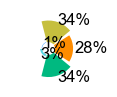

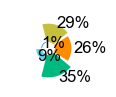

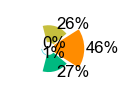

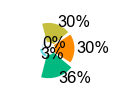

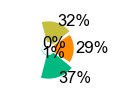

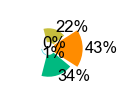

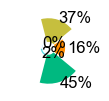

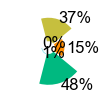

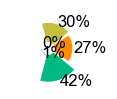

In [66]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from os.path import join

ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']

colors = ['#FF8C00', '#C6BF3E', '#1E90FF', '#56D7E3', '#00B980']
labels = ['强干旱', '弱干旱', '强洪涝', '弱洪涝', '无主导']

for ssp in ssps:
    for crop in crops:
        ds = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_{crop}_{ssp}_default.nc")
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        val_spei = ds['spei_to_yield_strength']
        pval_spei = ds['spei_to_yield_pval']
        val_ssi = ds['ssi_to_yield_strength']
        pval_ssi = ds['ssi_to_yield_pval']
        
        dominant_type = xr.full_like(val_spei, 4, dtype=int)
        
        cond_drought1 = ((pval_spei < 0.05) & (val_spei > 0.5)) | ((pval_ssi < 0.05) & (val_ssi > 0.5))
        cond_drought  = ((pval_spei < 0.05) & (val_spei > 0.3)) | ((pval_ssi < 0.05) & (val_ssi > 0.3))
        cond_flood1   = ((pval_ssi < 0.05) & (val_ssi < -0.5)) | ((pval_spei < 0.05) & (val_spei < -0.5))
        cond_flood    = ((pval_ssi < 0.05) & (val_ssi < -0.3)) | ((pval_spei < 0.05) & (val_spei < -0.3))
        
        dominant_type = dominant_type.where(~cond_drought, 1)
        dominant_type = dominant_type.where(~cond_flood, 3)
        dominant_type = dominant_type.where(~cond_drought1, 0)
        dominant_type = dominant_type.where(~cond_flood1, 2)
        dominant_type = dominant_type.where(area > 1000)
        
        area_masked = area.where(~np.isnan(dominant_type))
        proportions = []
        for t in range(5):
            mask = (dominant_type == t)
            proportions.append(float((area_masked.where(mask)).sum()))
        proportions = np.array(proportions)
        proportions = proportions / proportions.sum()
        
        # 玫瑰环形图实现
        theta = np.linspace(0, 2 * np.pi, len(proportions), endpoint=False)
        widths = 2 * np.pi / len(proportions)
        radii = proportions * 20  # 放大系数调节视觉效果

        fig, ax = plt.subplots(figsize=(1,1), subplot_kw=dict(polar=True))
        bars = ax.bar(theta, radii, width=widths*0.9, bottom=2, color=colors, edgecolor='none', linewidth=1)

        # 添加标签
        for i, bar in enumerate(bars):
            rotation = np.rad2deg(theta[i])
            alignment = 'left'
            ax.text(theta[i], radii[i] + 2.5, f"{proportions[i]*100:.0f}%", 
                    rotation=0, rotation_mode='anchor',
                    ha=alignment, va='center', fontsize=12)

        ax.set_ylim(0, 12)
        ax.set_axis_off()
        plt.savefig(rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\pie_{crop}_{ssp}_default.pdf', format='pdf', bbox_inches='tight', dpi=300)
        plt.show()


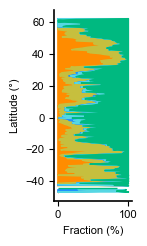

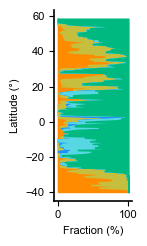

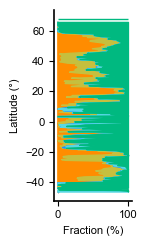

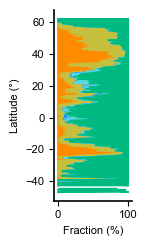

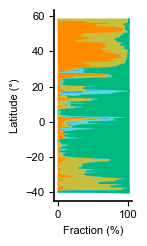

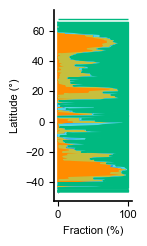

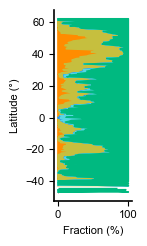

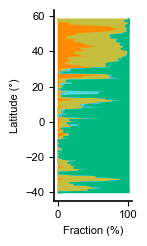

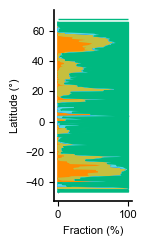

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

for ssp in ssps:
    for crop in crops:
        ds = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_{crop}_{ssp}_default.nc")
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        val_spei = ds['spei_to_yield_strength']
        pval_spei = ds['spei_to_yield_pval']
        val_ssi = ds['ssi_to_yield_strength']
        pval_ssi = ds['ssi_to_yield_pval']

        dominant_type = xr.full_like(val_spei, 4, dtype=int)

        cond_drought1 = ((pval_spei < 0.05) & (val_spei > 0.5)) | ((pval_ssi < 0.05) & (val_ssi > 0.5))
        cond_drought  = ((pval_spei < 0.05) & (val_spei > 0.3)) | ((pval_ssi < 0.05) & (val_ssi > 0.3))
        cond_flood1   = ((pval_ssi < 0.05) & (val_ssi < -0.5)) | ((pval_spei < 0.05) & (val_spei < -0.5))
        cond_flood    = ((pval_ssi < 0.05) & (val_ssi < -0.3)) | ((pval_spei < 0.05) & (val_spei < -0.3))

        dominant_type = dominant_type.where(~cond_drought, 1)
        dominant_type = dominant_type.where(~cond_flood, 3)
        dominant_type = dominant_type.where(~cond_drought1, 0)
        dominant_type = dominant_type.where(~cond_flood1, 2)
        dominant_type = dominant_type.where(area > 1000)

        labels = ['强干旱', '弱干旱', '强洪涝', '弱洪涝', '无主导']
        colors = ['#FF8C00', '#C6BF3E', '#1E90FF', '#56D7E3', '#00B980']

        lat_vals = dominant_type['lat'].values[::-1]
        lat_area = area.sum(dim='lon')  # 每纬度总面积

        # 准备数据
        stacked_data = np.zeros((5, len(lat_vals)))
        for t in range(5):
            mask = (dominant_type == t)
            area_t = area.where(mask).sum(dim='lon')
            prop_t = (area_t / lat_area) * 100
            stacked_data[t, :] = prop_t.values

        # 计算累积值用于水平堆积
        cum_data = np.cumsum(stacked_data, axis=0)

        fig, ax = plt.subplots(figsize=(1.5,2.5))

        # 绘制fill_betweenx实现水平堆积面积图
        ax.fill_betweenx(lat_vals, 0, cum_data[0, :], color=colors[0], label=labels[0])
        for i in range(1, 5):
            ax.fill_betweenx(lat_vals, cum_data[i-1, :], cum_data[i, :], color=colors[i], label=labels[i])

        ax.set_ylabel('Latitude (°)')
        ax.set_xlabel('Fraction (%)')
        ax.grid(False)

        # 去掉右侧和上方边框
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)

        # ax.legend(loc='upper right')
        plt.tight_layout()
        # plt.savefig(rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\lat_distribution_stacked_horizontal_{crop}_{ssp}.pdf', dpi=300)
        plt.show()


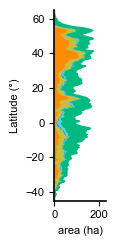

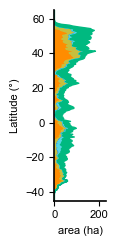

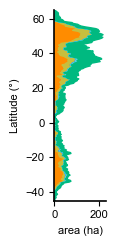

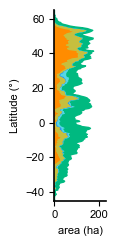

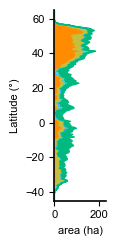

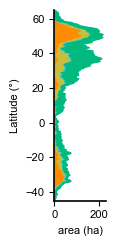

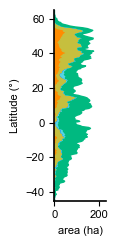

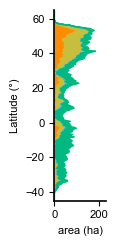

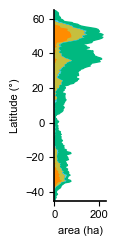

In [130]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
for ssp in ssps:
    for crop in crops:
        ds = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_{crop}_{ssp}_default.nc")
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        val_spei = ds['spei_to_yield_strength']
        pval_spei = ds['spei_to_yield_pval']
        val_ssi = ds['ssi_to_yield_strength']
        pval_ssi = ds['ssi_to_yield_pval']

        dominant_type = xr.full_like(val_spei, 4, dtype=int)

        cond_drought1 = ((pval_spei < 0.05) & (val_spei > 0.5)) | ((pval_ssi < 0.05) & (val_ssi > 0.5))
        cond_drought  = ((pval_spei < 0.05) & (val_spei > 0.3)) | ((pval_ssi < 0.05) & (val_ssi > 0.3))
        cond_flood1   = ((pval_ssi < 0.05) & (val_ssi < -0.5)) | ((pval_spei < 0.05) & (val_spei < -0.5))
        cond_flood    = ((pval_ssi < 0.05) & (val_ssi < -0.3)) | ((pval_spei < 0.05) & (val_spei < -0.3))

        dominant_type = dominant_type.where(~cond_drought, 1)
        dominant_type = dominant_type.where(~cond_flood, 3)
        dominant_type = dominant_type.where(~cond_drought1, 0)
        dominant_type = dominant_type.where(~cond_flood1, 2)
        dominant_type = dominant_type.where(area > 1000)

        labels = ['强干旱', '弱干旱', '强洪涝', '弱洪涝', '无主导']
        colors = ['#FF8C00', '#C6BF3E', '#1E90FF', '#56D7E3', '#00B980']

        lat_vals = dominant_type['lat'].values[::-1]
        lat_area = area.sum(dim='lon')  # 每纬度总面积

        # 准备数据
        stacked_data = np.zeros((5, len(lat_vals)))
        for t in range(5):
            mask = (dominant_type == t)
            area_t = area.where(mask).sum(dim='lon')
            # prop_t = (area_t / lat_area) * 100
            prop_t = area.where(mask).count(dim='lon')
            stacked_data[t, :] = prop_t.values

        # 计算累积值用于水平堆积
        cum_data = np.cumsum(stacked_data, axis=0)

        fig, ax = plt.subplots(figsize=(1.2,2.5))

        # 绘制fill_betweenx实现水平堆积面积图
        ax.fill_betweenx(lat_vals, 0, cum_data[0, :], color=colors[0], label=labels[0])
        for i in range(1, 5):
            ax.fill_betweenx(lat_vals, cum_data[i-1, :], cum_data[i, :], color=colors[i], label=labels[i])

        ax.set_ylabel('Latitude (°)')
        ax.set_xlabel('area (ha)')
        ax.grid(False)

        # 去掉右侧和上方边框
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)
        ax.set_ylim( -45, 65)
        # ax.set_xlim( 0, 5e10)
        ax.set_xlim( 0, 230)
        # ax.legend(loc='upper right')
        plt.tight_layout()
        plt.savefig(rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\lat_distribution_stacked_horizontal_{crop}_{ssp}.pdf', dpi=300)
        plt.show()


mai_historical: 67.40 ± 21.53


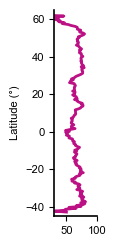

soy_historical: 71.84 ± 20.03


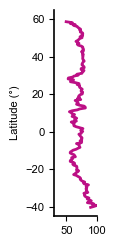

whe_historical: 72.32 ± 20.87


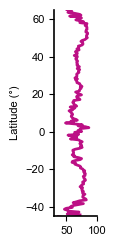

mai_ssp126: 67.29 ± 20.97


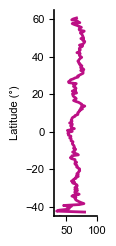

soy_ssp126: 71.58 ± 20.76


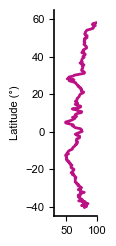

whe_ssp126: 67.22 ± 21.15


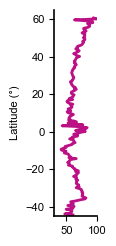

mai_ssp585: 63.89 ± 20.47


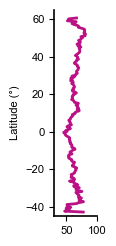

soy_ssp585: 66.60 ± 20.31


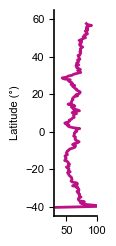

whe_ssp585: 63.64 ± 21.24


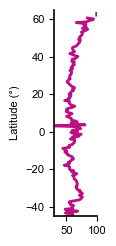

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_latitude_profile(prob_da, vmax=100, vmin=0, xlabel='Probability (%)', save_path=None):
    # 按经度方向平均
    lat_mean = prob_da.mean(dim='lon', skipna=True)
    
    fig, ax = plt.subplots(figsize=(1.2,2.5))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8
    ax.plot(lat_mean, lat_mean['lat'], color='#BC1085', linewidth=2)
    
    ax.set_ylabel('Latitude (°)')
    # ax.set_xlabel(xlabel)
    ax.set_ylim( -45, 65)
    ax.set_xlim(vmin, vmax)
    
    # 保持纬度从小到大，如果想倒转用 ax.invert_yaxis()
    # ax.invert_yaxis()
    
    ax.grid(False)  # 不显示网格

    # 去掉右侧和上方边框
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # 保留左和下边框
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    
    plt.tight_layout()
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
exp='default'
# 调用示例：
for ssp in ssps:
    if ssp == 'historical':
        idx = 0
    else:
        idx = 0
    for crop in crops:
        expect_yield = result_dict2[exp][ssp][crop]['expect_yield'][:]
        yied = result_dict1[exp][ssp][crop]['yield'][-idx:]
        expect_yield = expect_yield[-len(yied):]
        expect_yield = expect_yield[-idx:]
        expect_yield['time'] = yied.time.values
        yield_loss = (yied - expect_yield) / yied * 100
        
        ssi = result_dict1[exp][ssp][crop]['ssi'][-idx:]
        spei = result_dict1[exp][ssp][crop]['spei'][-idx:]
        drought_mask = (ssi < -0.42)
        prob = (((yield_loss < 0) & drought_mask).sum(dim='time') / drought_mask.sum(dim='time')) * 100
        prob = prob.where(prob != 0)
        print(f'{crop}_{ssp}: {prob.mean(skipna=True).values:.2f} ± {prob.std(skipna=True).values:.2f}')
        
        plot_latitude_profile(prob, vmax=100, vmin=30,
                              save_path=rf'D:\AAUDE\paper\paper8\manu\ftt\{crop}_{ssp}_probability_loss_latitude.pdf')


mai_historical: 67.40 ± 21.53


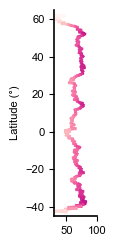

soy_historical: 71.84 ± 20.03


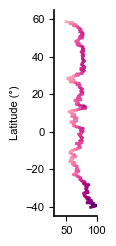

whe_historical: 72.32 ± 20.87


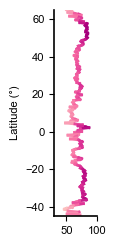

mai_ssp126: 67.29 ± 20.97


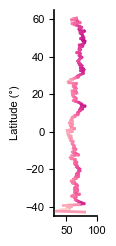

soy_ssp126: 71.58 ± 20.76


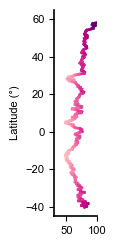

whe_ssp126: 67.22 ± 21.15


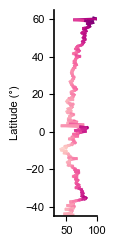

mai_ssp585: 63.89 ± 20.47


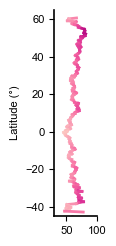

soy_ssp585: 66.60 ± 20.31


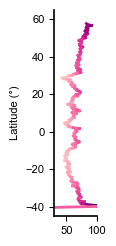

whe_ssp585: 63.64 ± 21.24


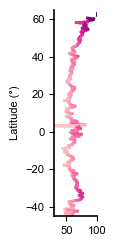

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

def plot_latitude_profile(prob_da, vmax=100, vmin=30, xlabel='Probability (%)', save_path=None):
    # 按经度方向平均
    lat_mean = prob_da.mean(dim='lon', skipna=True)
    
    fig, ax = plt.subplots(figsize=(1.2, 2.5))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8
    
    # 创建颜色映射 (RdPu colormap)
    cmap = plt.get_cmap('RdPu')
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    # 为每个纬度点创建渐变颜色
    latitudes = lat_mean['lat'].values
    prob_values = lat_mean.values
    
    # 绘制渐变线
    for i in range(len(latitudes)-1):
        ax.plot([prob_values[i], prob_values[i+1]], 
                [latitudes[i], latitudes[i+1]], 
                color=cmap(norm((prob_values[i]+prob_values[i+1])/2)),  # 取中间值颜色
                linewidth=2)
    
    # 添加colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # cbar = plt.colorbar(sm, ax=ax, pad=0.02, aspect=10)
    # cbar.set_label(xlabel, labelpad=2)
    
    ax.set_ylabel('Latitude (°)')
    ax.set_ylim(-45, 65)
    ax.set_xlim(vmin, vmax)
    
    ax.grid(False)  # 不显示网格

    # 去掉右侧和上方边框
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # 保留左和下边框
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# 调用示例
exp = 'default'
for ssp in ssps:
    if ssp == 'historical':
        idx = 0
    else:
        idx = 0
    for crop in crops:
        expect_yield = result_dict2[exp][ssp][crop]['expect_yield'][:]
        yied = result_dict1[exp][ssp][crop]['yield'][-idx:]
        expect_yield = expect_yield[-len(yied):]
        expect_yield = expect_yield[-idx:]
        expect_yield['time'] = yied.time.values
        yield_loss = (yied - expect_yield) / yied * 100
        
        ssi = result_dict1[exp][ssp][crop]['ssi'][-idx:]
        spei = result_dict1[exp][ssp][crop]['spei'][-idx:]
        drought_mask = (ssi < -0.42)
        prob = (((yield_loss < 0) & drought_mask).sum(dim='time') / drought_mask.sum(dim='time')) * 100
        prob = prob.where(prob != 0)
        print(f'{crop}_{ssp}: {prob.mean(skipna=True).values:.2f} ± {prob.std(skipna=True).values:.2f}')
        
        plot_latitude_profile(prob, vmax=100, vmin=30,
                            save_path=rf'D:\AAUDE\paper\paper8\manu\ftt\{crop}_{ssp}_probability_loss_latitude.pdf')

mai_historical: -9.60 ± 16.99


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


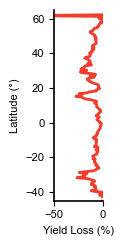

soy_historical: -11.04 ± 13.14


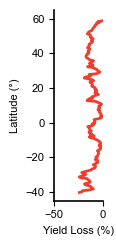

whe_historical: -16.74 ± 26.84


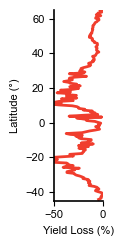

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


mai_ssp126: -7.92 ± 14.50


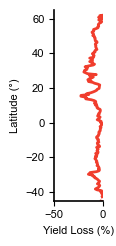

soy_ssp126: -8.36 ± 11.49


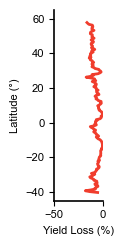

whe_ssp126: -13.08 ± 24.09


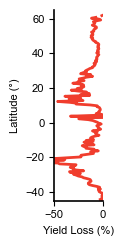

mai_ssp585: -7.51 ± 14.68


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


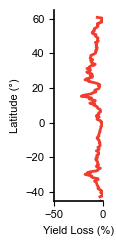

soy_ssp585: -7.37 ± 12.03


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


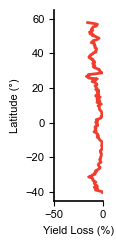

whe_ssp585: -13.12 ± 26.41


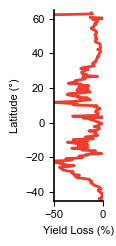

In [138]:
import matplotlib.pyplot as plt

def plot_latitude_profile(prob_da, vmax=100, vmin=0, xlabel='Yield Loss (%)', save_path=None):
    # 按经度方向平均
    lat_mean = prob_da.mean(dim='lon', skipna=True)
    
    fig, ax = plt.subplots(figsize=(1.2,2.5))
    ax.plot(lat_mean, lat_mean['lat'], color='#F03D2D', linewidth=2)
    
    ax.set_ylabel('Latitude (°)')
    ax.set_xlabel(xlabel)
    ax.set_ylim( -45, 65)
    ax.set_xlim(vmin, vmax)
    
    # 保持纬度从小到大，如果想倒转用 ax.invert_yaxis()
    # ax.invert_yaxis()
    
    ax.grid(False)  # 不显示网格

    # 去掉右侧和上方边框
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # 保留左和下边框
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# 调用示例：
for ssp in ssps:
    if ssp == 'historical':
        idx = 0
    else:
        idx = 0
    for crop in crops:
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        expect_yield = result_dict2[ssp][crop]['expect_yield'][:]
        yied = result_dict1[ssp][crop]['yield'][-idx:]
        expect_yield = expect_yield[-len(yied):]
        expect_yield = expect_yield[-idx:]
        expect_yield['time'] = yied.time.values
        yield_loss = (yied - expect_yield) / yied * 100
        
        ssi = result_dict1[ssp][crop]['ssi'][-idx:]
        spei = result_dict1[ssp][crop]['spei'][-idx:]
        drought_mask = (ssi < -0.42)
        prob = yield_loss.where(drought_mask).mean(dim='time')
        prob=prob.where(abs(prob)<200)
        print(f'{crop}_{ssp}: {prob.mean(skipna=True).values:.2f} ± {prob.std(skipna=True).values:.2f}')
        
        plot_latitude_profile(prob.where(area>1000), vmax=0, vmin=-50,
                              save_path=rf'D:\AAUDE\paper\paper8\manu\ftt\{crop}_{ssp}_Yield_loss_latitude.pdf')


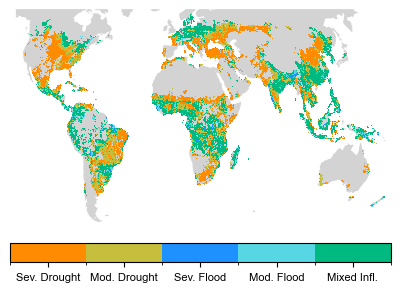

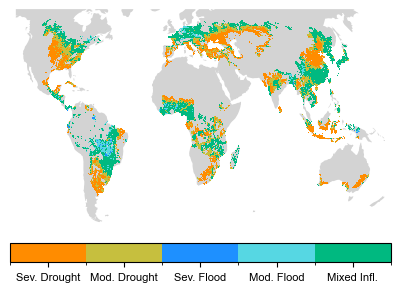

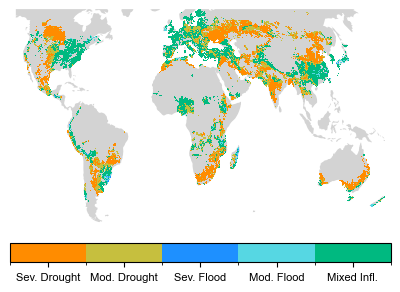

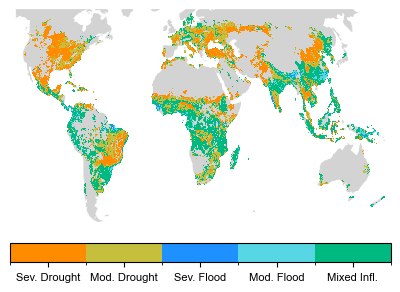

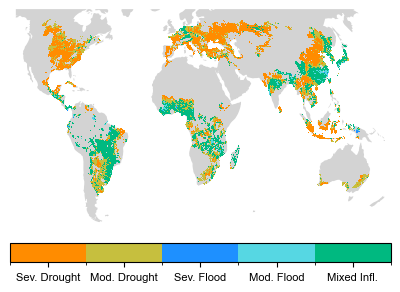

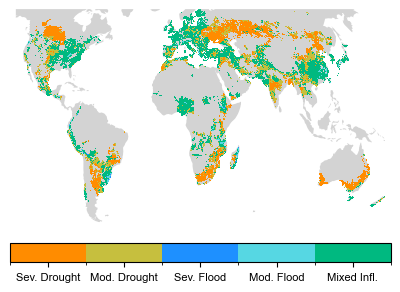

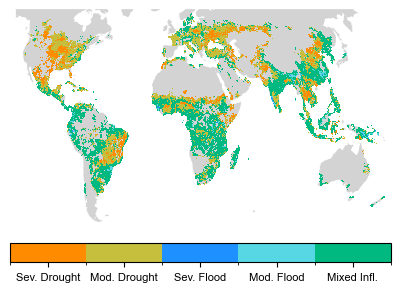

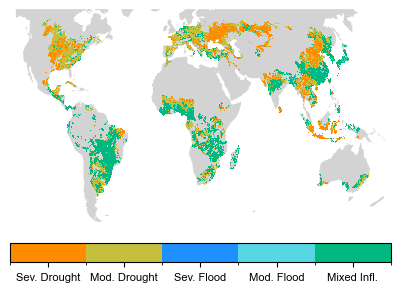

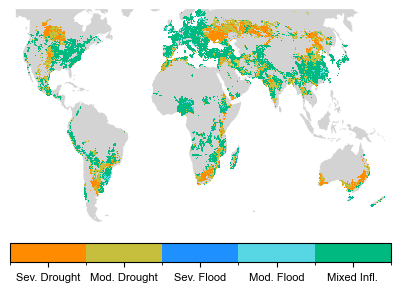

In [35]:
import numpy as np
import xarray as xr
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
for ssp in ssps:
    for crop in crops:
        ds = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_{crop}_{ssp}_default.nc")
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        val_spei = ds['spei_to_yield_strength']
        pval_spei = ds['spei_to_yield_pval']
        val_ssi = ds['ssi_to_yield_strength']
        pval_ssi = ds['ssi_to_yield_pval']
        
        
        dominant_type = xr.full_like(val_spei, 4, dtype=int)  # 初始化为4，代表“无主导”或“未分类”
        
        # 条件先定义，注意这里是替换条件，不用取反
        cond_drought1 = ((pval_spei < 0.05) & (val_spei > 0.5)) | ((pval_ssi < 0.05) & (val_ssi > 0.5))  # 强干旱
        cond_drought = ((pval_spei < 0.05) & (val_spei > 0.3)) | ((pval_ssi < 0.05) & (val_ssi > 0.3))    # 弱干旱
        
        cond_flood1 = ((pval_ssi < 0.05) & (val_ssi < -0.5)) | ((pval_spei < 0.05) & (val_spei < -0.5))  # 强洪涝
        cond_flood = ((pval_ssi < 0.05) & (val_ssi < -0.3)) | ((pval_spei < 0.05) & (val_spei < -0.3))   # 弱洪涝
        
        # 先赋予强条件
        
        
        # 再赋予弱条件（只有原值不是强条件才会赋）
        dominant_type = dominant_type.where(~cond_drought,1)  # 弱干旱赋1
        dominant_type = dominant_type.where(~cond_flood,3)    # 弱洪涝赋2
        dominant_type = dominant_type.where(~cond_drought1, 0)  # 强干旱赋0
        dominant_type = dominant_type.where(~cond_flood1, 2)    # 强洪涝赋3
        # dominant_type.name = "dominant_type"
        dominant_type.attrs["long_name"] = "主导类型（0强干旱，1弱干旱，2强洪涝，3弱洪涝，4主导）"

        dominant_type=dominant_type.where(area>1000)
        dominant_type.to_netcdf(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}_default.nc")
        draw_dominant(dominant_type,crop,ssp,rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\dominant_type_{crop}_{ssp}_default.pdf')

In [34]:
def draw_dominant(dominant_type, crop, ssp, save_path):
    # cmap = mcolors.ListedColormap(['#c9413a', '#da6761', '#396795', '#7096b8','#5daf5c'])
    cmap = mcolors.ListedColormap(['#FF8C00', '#C6BF3E', '#1E90FF', '#56D7E3','#00B980'])
    bounds = [0, 1, 2, 3, 4, 5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    labels = {
        0: 'Sev. Drought',
        1: 'Mod. Drought',
        2: 'Sev. Flood',
        3: 'Mod. Flood',
        4: 'Mixed Infl.'
    }

    # regions = gpd.read_file("region_mask_regions.shp")

    fig = plt.figure(figsize=(5, 3))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8

    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.set_extent([-120, 160, -60, 65], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    # ax.add_feature(cfeature.OCEAN, facecolor='#a6cee3')
    ax.spines['geo'].set_visible(False)

    im = ax.pcolormesh(dominant_type.lon, dominant_type.lat, dominant_type,
                       cmap=cmap, norm=norm, shading='auto',
                       transform=ccrs.PlateCarree())

    # regions.plot(ax=ax, facecolor='none', edgecolor='#4e4e4e', linewidth=0.7,
    #              zorder=5, transform=ccrs.PlateCarree())

    ax.set_aspect(1.2)
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal',
                       ticks=[0.5, 1.5, 2.5, 3.5, 4.5], shrink=0.8, pad=0.05)
    cbar.ax.set_xticklabels([labels[i] for i in range(5)])
    # cbar.set_label('Dominant Type')

    plt.tight_layout()
    plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
# draw_dominant(dominant_type,crop,ssp,rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\dominant_type_{crop}_{ssp}_default.pdf')

ERROR! Session/line number was not unique in database. History logging moved to new session 1004


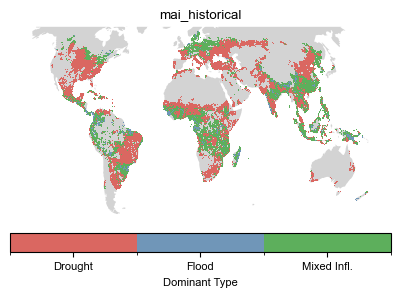

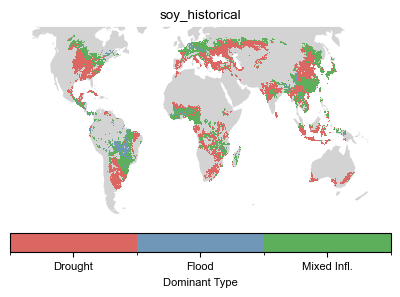

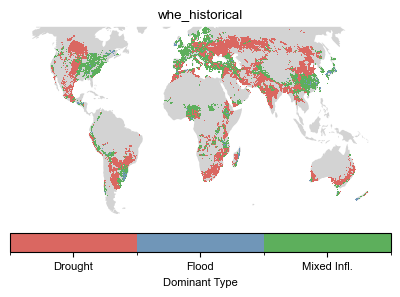

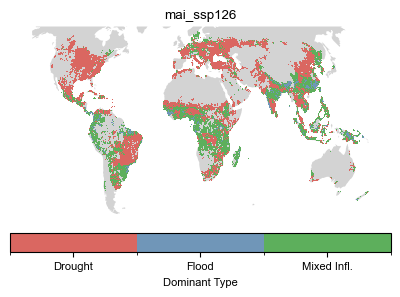

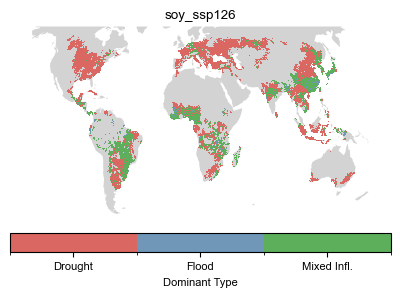

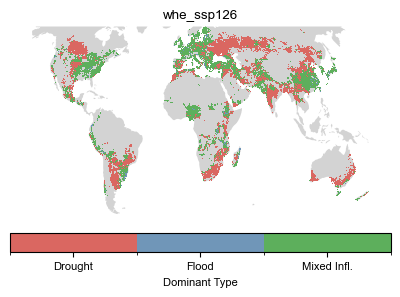

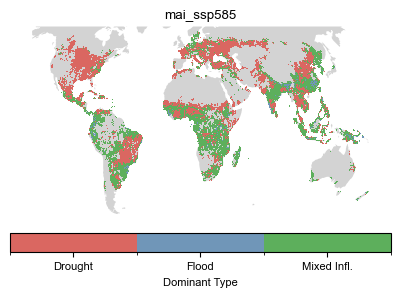

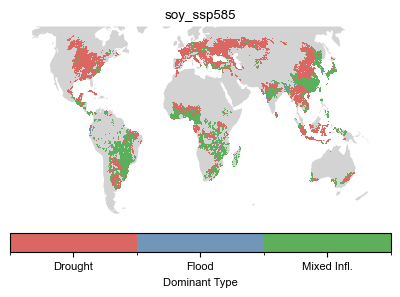

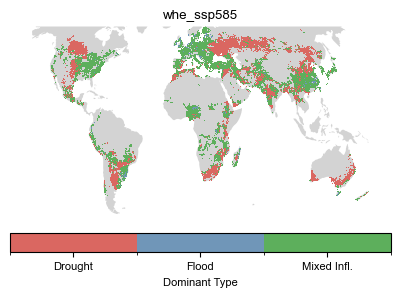

In [6]:
import numpy as np
import xarray as xr
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
for ssp in ssps:
    for crop in crops:
        ds = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_{crop}_{ssp}_default.nc")
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        val_spei = ds['spei_to_yield_strength']
        pval_spei = ds['spei_to_yield_pval']
        val_ssi = ds['ssi_to_yield_strength']
        pval_ssi = ds['ssi_to_yield_pval']
        
        
        dominant_type = xr.full_like(val_spei, 3, dtype=int)  # 初始化为4，代表“无主导”或“未分类”
        
        # 条件先定义，注意这里是替换条件，不用取反
        # cond_drought1 = ((pval_spei < 0.05) & (val_spei > 0.5)) | ((pval_ssi < 0.05) & (val_ssi > 0.5))  # 强干旱
        cond_drought = ((pval_spei < 0.05) & (val_spei > 0.3)) | ((pval_ssi < 0.05) & (val_ssi > 0.3))    # 弱干旱
        
        # cond_flood1 = ((pval_ssi < 0.05) & (val_ssi < -0.5)) | ((pval_spei < 0.05) & (val_spei < -0.5))  # 强洪涝
        cond_flood = ((pval_ssi < 0.05) & (val_ssi < -0.3)) | ((pval_spei < 0.05) & (val_spei < -0.3))   # 弱洪涝
        
        # 先赋予强条件
        
        
        # 再赋予弱条件（只有原值不是强条件才会赋）
        dominant_type = dominant_type.where(~cond_drought,1)  # 弱干旱赋1
        dominant_type = dominant_type.where(~cond_flood,2)    # 弱洪涝赋2
        # dominant_type = dominant_type.where(~cond_drought1, 0)  # 强干旱赋0
        # dominant_type = dominant_type.where(~cond_flood1, 2)    # 强洪涝赋3
        dominant_type.name = "dominant_type"
        dominant_type.attrs["long_name"] = "主导类型（0强干旱，1弱干旱，2强洪涝，3弱洪涝，4主导）"

        dominant_type=dominant_type.where(area>1000)
        dominant_type.to_netcdf(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}_default.nc")
        draw_dominant(dominant_type,crop,ssp,rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\dominant_type_{crop}_{ssp}_default.pdf')

In [5]:
import matplotlib as mpl
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def draw_dominant(dominant_type,crop,ssp,save_path):
    # 将0值替换为NaN，这样就不会显示
    dominant_type = dominant_type.where(dominant_type != 0)
    
    # 调整颜色映射和边界，去掉0对应的部分
    cmap = mcolors.ListedColormap(['#da6761', '#7096b8', '#5daf5c'])  # 只保留1,2,3对应的颜色
    bounds = [1, 2, 3, 4]  # 边界调整为从1开始
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    labels = {
        1: 'Drought',
        2: 'Flood',
        3: 'Mixed Infl.'
    }
    
    # 绘图
    fig = plt.figure(figsize=(5,3))
    mpl.rcParams['pdf.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8

    # ax = plt.axes(projection=ccrs.PlateCarree())
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_extent([-120, 160, -60, 65], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    # ax.coastlines(linewidth=0.5)
    # ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.spines['geo'].set_visible(False)
    
    # 绘制处理后的数据（已去除0值）
    im = plt.pcolormesh(dominant_type.lon, dominant_type.lat, dominant_type,
                        cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    

    ax.set_aspect(1.2)
    # 调整颜色条刻度，只保留1,2,3对应的位置
    cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal',
                              ticks=[1.5, 2.5, 3.5], shrink=0.8, pad=0.05)
    cbar.ax.set_xticklabels([labels[i] for i in range(1,4)])  # 只显示1,2,3的标签
    cbar.set_label('Dominant Type')
    
    plt.title(f'{crop}_{ssp}')
    plt.tight_layout()
    # plt.savefig(
    #     save_path,
    #     format='pdf',
    #     bbox_inches='tight',
    #     dpi=300,
    # )
    plt.show()

In [146]:
import xarray as xr
import numpy as np

# 作物列表
crops = ['mai', 'soy', 'whe']

# 读取每个作物的主导类型数据，并将 NaN 填为 0
dominant_types = []
for crop in crops:
    ds = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_historical_default.nc")['dominant_type']
    dominant_types.append(ds.fillna(0))

# 合并为 DataArray，新增 crop 维度
stacked = xr.concat(dominant_types, dim='crop')
stacked['crop'] = crops

# 定义优先级合并函数
def combine_types(arr):
    arr = arr.astype(int)
    unique_vals = set(arr[arr != 0])  # 去除未知（0）
    
    if len(unique_vals) == 0:
        return 0  # 全为未知
    
    if 3 in unique_vals:
        return 3  # 任一为共同主导
    
    if len(unique_vals) == 1:
        return unique_vals.pop()  # 所有一致（干旱或洪涝）
    
    return 3  # 不一致，设为共同主导

# 应用函数（向量化处理）
combined = xr.apply_ufunc(
    combine_types,
    stacked,
    input_core_dims=[["crop"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int]
)

# 设置属性
combined.name = "combined_dominant_type"
combined.attrs['description'] = "主导类型整合结果：0未知，1干旱主导，2洪涝主导，3共同主导"

# 保存结果
combined.to_netcdf(r"D:\AAUDE\paper\paper8\data\PCMCI\combined_dominant_type_global_v2.nc")


In [46]:
combined_masked = combined.where(total_area > 0)

# 设置空间信息
combined_masked = combined_masked.rename({'lat': 'y', 'lon': 'x'})
combined_masked.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
combined_masked.rio.write_crs("EPSG:4326", inplace=True)

# 保存为 GeoTIFF，nodata 使用默认 NaN（float 类型）或你指定的值
combined_masked.rio.to_raster(
    "D:/AAUDE/paper/paper8/data/PCMCI/combined_dominant_type_global.tif",
    nodata=np.nan,  # 保留原始 NaN 为 NoData
    compress="LZW"  # 推荐压缩算法，减少文件大小
)


In [47]:
combined.where(total_area>0).to_netcdf("D:/AAUDE/paper/paper8/data/PCMCI/combined_dominant_type_global.nc")

In [147]:
import xarray as xr
from os.path import join

crops = ['mai', 'soy', 'whe']
total_area = None

for crop in crops:
    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
    ds = xr.open_dataset(area_path)
    var_name = list(ds.data_vars)[0]  # 获取变量名
    area = ds[var_name]

    if total_area is None:
        total_area = area.fillna(0)
    else:
        total_area += area.fillna(0)

# 保存结果（可选）
total_area.name = "total_crop_area"
total_area.attrs['description'] = "SPAM2020三种作物总面积"
# total_area.to_netcdf(r"D:\AAUDE\paper\paper8\data\area\total_crop_area.nc")


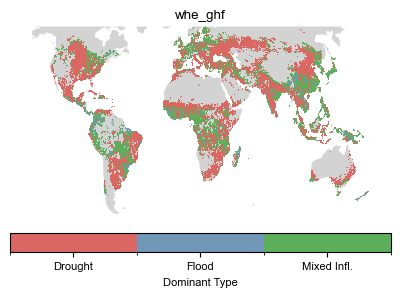

In [165]:
combined=xr.open_dataset(r"D:/AAUDE/paper/paper8/data/PCMCI/combined_dominant_type_global.nc").combined_dominant_type
combined=combined.where(combined!=0,3)
draw_dominant(combined.where(total_area > 0),crop,'ghf',rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\comnined.pdf')

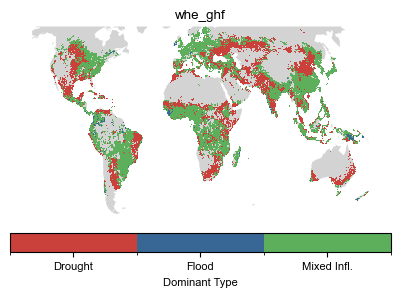

In [157]:
draw_dominant(combined.where(total_area > 0),crop,'ghf',rf'D:\AAUDE\paper\paper8\manu\fig\fig_domate\comnined.pdf')

In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def draw_dominant(dominant_type,crop,ssp):
    cmap = mcolors.ListedColormap(['lightgray', 'darkorange', 'dodgerblue', 'green'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    labels = {
        0: 'Unknown',
        1: 'Drought',
        2: 'Flood',
        3: 'Co-effcet'
    }
    
    # 绘图
    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -60, 70], crs=ccrs.PlateCarree())
    
    plt.rcParams["font.family"] = "Times New Roman"
    
    im = plt.pcolormesh(dominant_type.lon, dominant_type.lat, dominant_type,
                        cmap=cmap, norm=norm)
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.spines['geo'].set_visible(False)
    
    cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal',
                              ticks=[0.5, 1.5, 2.5, 3.5], shrink=0.8, pad=0.05)
    cbar.ax.set_xticklabels([labels[i] for i in range(4)])
    cbar.set_label('Dominant Type')
    
    plt.title(f'{crop}_{ssp}')
    # plt.xlabel('Longitude')
    # plt.ylabel('Latitude')
    plt.tight_layout()
    # plt.savefig(rf'D:\AAUDE\paper\paper8\fig_pcmic\doniminatant_{crop}_{ssp}.svg')
    plt.show()


ERROR! Session/line number was not unique in database. History logging moved to new session 445


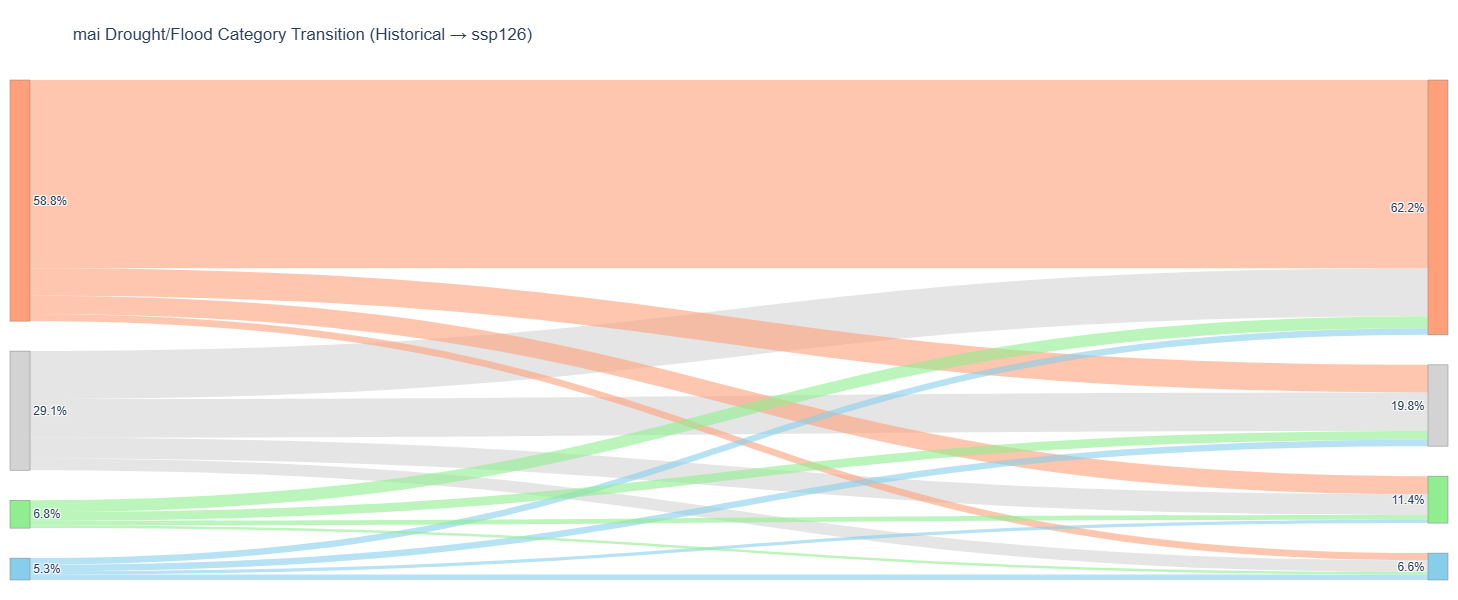

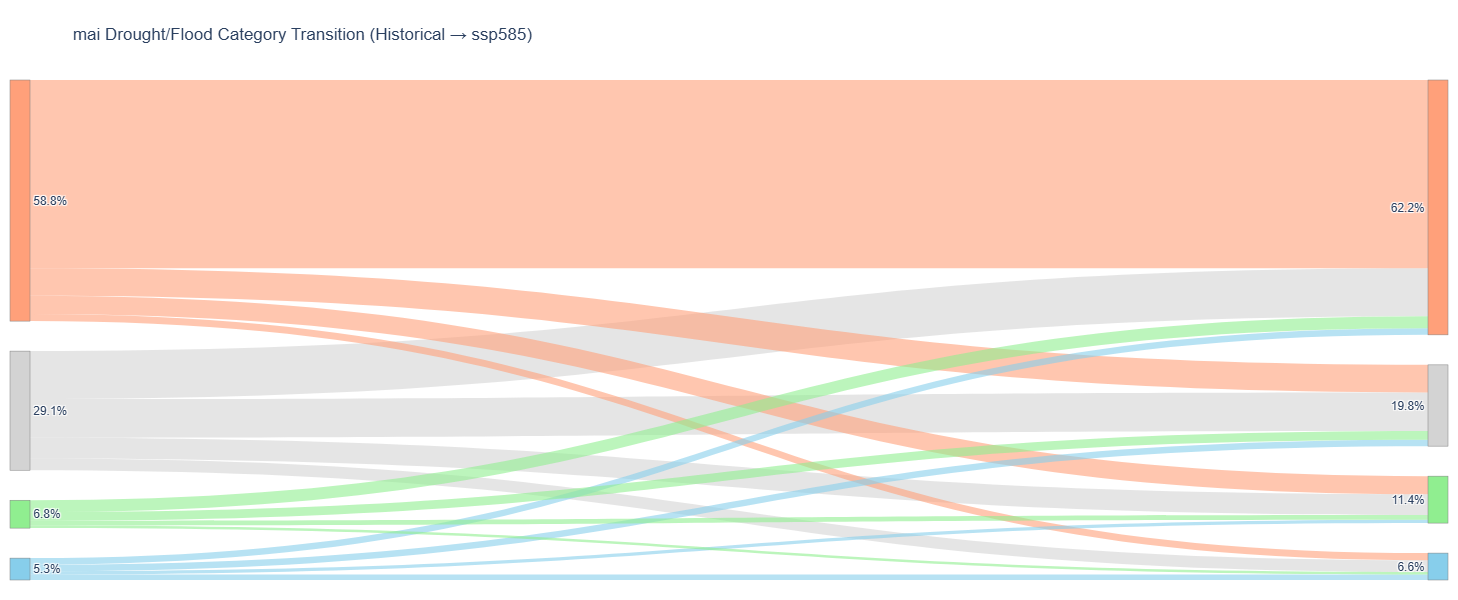

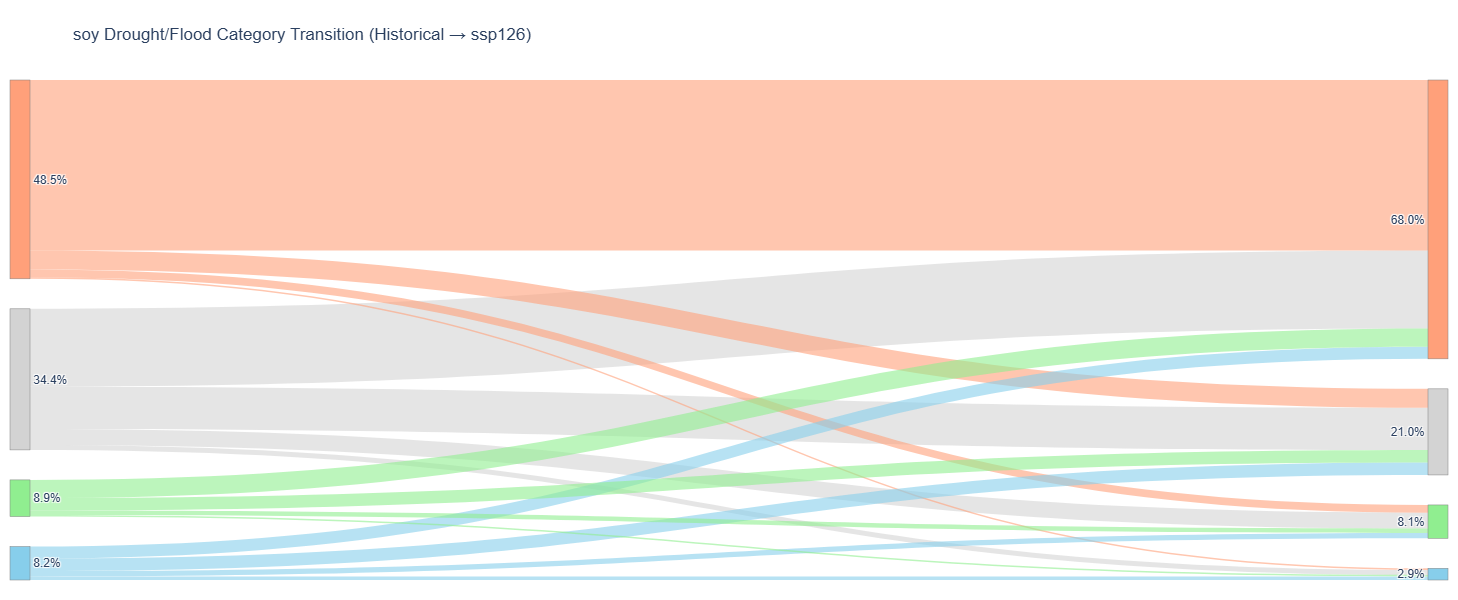

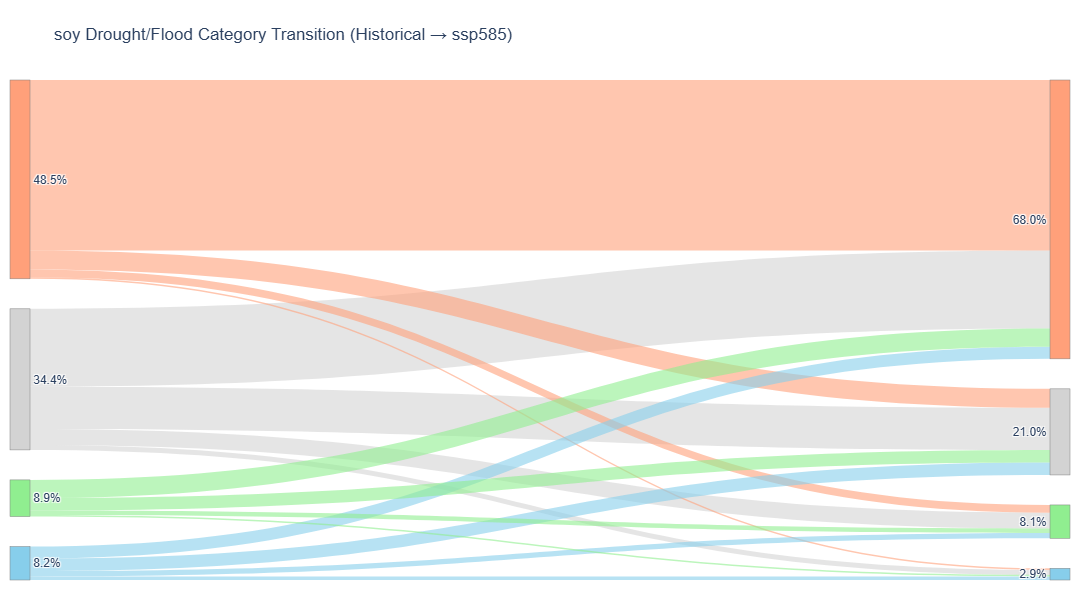

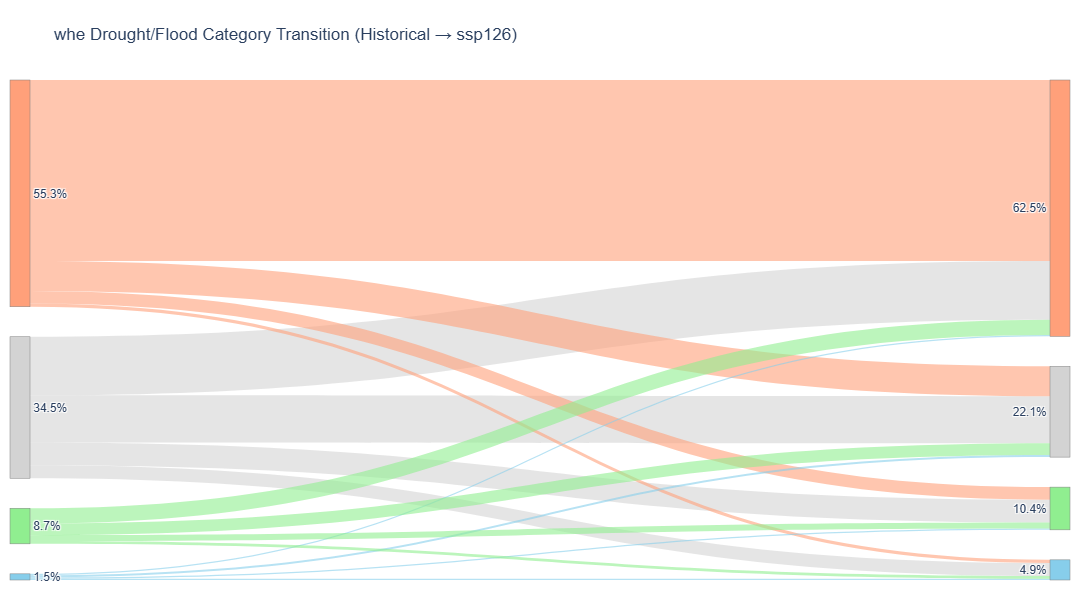

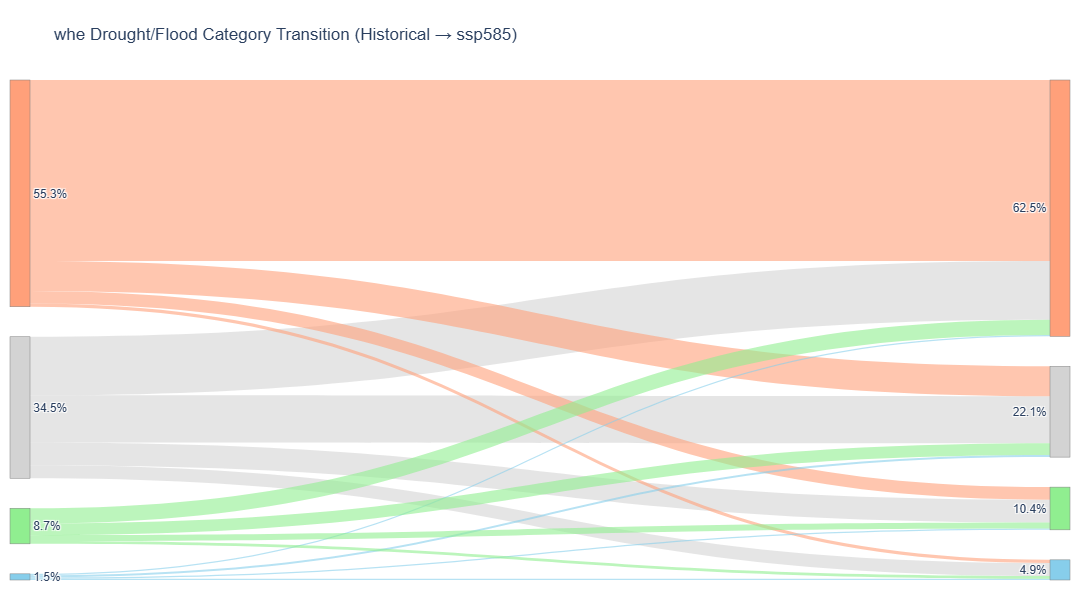

In [9]:
import numpy as np
import xarray as xr
import pandas as pd
import plotly.graph_objects as go
from matplotlib.colors import to_rgba
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_sankey_for_crop_single_future(crop, historical_ssp, future_ssp):
    hist_class = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_historical.nc").dominant_type
    future_class = xr.open_dataset(rf"D:\AAUDE\paper\paper8\data\PCMCI\dominant_type_{crop}_{ssp}.nc").dominant_type

    if hist_class.shape != future_class.shape:
        raise ValueError(f"历史情景和{future_ssp}情景的形状不匹配")

    valid_mask = np.isfinite(hist_class) & np.isfinite(future_class)

    matrix = np.zeros((4, 4), dtype=int)
    for i in range(4):
        for j in range(4):
            mask = (hist_class == i) & (future_class == j) & valid_mask
            matrix[i, j] = np.sum(mask)

    hist_total = np.sum(np.isfinite(hist_class) & valid_mask)
    future_total = np.sum(np.isfinite(future_class) & valid_mask)

    order = [0, 1, 2, 3]  # D, F, C, N固定顺序

    hist_counts = [(hist_class == i).where(valid_mask, drop=True).sum().item() for i in order]
    future_counts = [(future_class == i).where(valid_mask, drop=True).sum().item() for i in order]
    hist_percents = [100 * c / hist_total if hist_total > 0 else 0 for c in hist_counts]
    future_percents = [100 * c / future_total if future_total > 0 else 0 for c in future_counts]

    eng_labels = ['D', 'F', 'C', 'N']
    eng_label_meanings = ['Unknown','Dry', 'Flood', 'Co-effect']

    # hist_labels = [f" ({eng_label_meanings[i]}) {hist_percents[idx]:.1f}%" for idx, i in enumerate(order)]
    # future_labels = [f" ({eng_label_meanings[i]}) {future_percents[idx]:.1f}%" for idx, i in enumerate(order)]
    hist_labels = [f"{hist_percents[idx]:.1f}%" for idx, i in enumerate(order)]
    future_labels = [f" {future_percents[idx]:.1f}%" for idx, i in enumerate(order)]
    all_labels = hist_labels + future_labels

    category_colors = ['#D3D3D3','#FFA07A', '#87CEEB', '#90EE90']

    # **初始化连接相关变量**
    sources = []
    targets = []
    values = []
    link_colors = []

    for idx_i, i in enumerate(order):
        for idx_j, j in enumerate(order):
            if matrix[i, j] > 0:
                sources.append(idx_i)
                targets.append(idx_j + 4)
                values.append(matrix[i, j])
                rgba = to_rgba(category_colors[i])
                rgba_str = f"rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, 0.6)"
                link_colors.append(rgba_str)

    fig = go.Figure(go.Sankey(
        # arrangement="snap",
        arrangement='perpendicular',
        node=dict(
            pad=30,
            thickness=20,
            line=dict(width=0.5, color='gray'),
            label=all_labels,
            color=category_colors * 2
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            hovertemplate='%{source.label} → %{target.label}<br>数量: %{value}<extra></extra>'
        )
    ))

    fig.update_layout(
        title_text=f"{crop} Drought/Flood Category Transition (Historical → {future_ssp})",
        font=dict(family="Arial", size=12),
        height=600,
        margin=dict(t=80, l=10, r=10, b=20),
        hoverlabel=dict(bgcolor="white", font_size=12)
    )
    return fig

for crop in crops:
    for future_ssp in ssps[1:]:
        fig = plot_sankey_for_crop_single_future(crop, 'historical', future_ssp)
        
        # fig.write_html(f"sankey_{crop}_historical_to_{future_ssp}.html")
        fig.write_image(rf"D:\AAUDE\paper\paper8\fig_pcmic\sankey_{crop}_historical_to_{future_ssp}.pdf")
        fig.show()

In [11]:
ssp585=xr.open_dataset(r"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_whe_ssp585_gpdc_default.nc")
his=xr.open_dataset(r"D:\AAUDE\paper\paper8\data\PCMCI\pcmci_whe_historical_gpdc_default.nc")
ssp585

<xarray.Dataset> Size: 8MB
Dimensions:                 (lat: 360, lon: 720)
Coordinates:
  * lat                     (lat) float64 3kB 89.75 89.25 ... -89.25 -89.75
  * lon                     (lon) float64 6kB -179.8 -179.2 ... 179.2 179.8
Data variables:
    ssi_to_yield_strength   (lat, lon) float64 2MB ...
    ssi_to_yield_pval       (lat, lon) float64 2MB ...
    spei_to_yield_strength  (lat, lon) float64 2MB ...
    spei_to_yield_pval      (lat, lon) float64 2MB ...